# Предсказване на изборни резултати в САЩ

## Идея
Анализирането на връзките между различни демографски фактори (като доходи, образование и етнически състав) и изборни резултати е от изключителна важност за придобиване на по-дълбоко разбиране на все по-поляризираната американска политическа сцена. Целта на този проект е анализирането на демографски данни и резултати от президентските избори през 2020 година в САЩ за всеки един окръг (county) или еквивалент на окръг (county equivalent) и създаването на модел, който предсказва резултата от избори за даден хипотетичен окръг. </br> </br>
*Терминология:* 
- **окръг (county)** - административна подединица на щат или територия в САЩ със строго определени географски граници и силно ограничена форма на автономност
- **еквивалент на окръг (county equivalent)** - поради исторически причини, в щатите Аляска и Луизиана терминът **окръг (county)** не се използва, а се използват респективно *боро (borough)* и *парохия (parish)*

Нека инсталираме нужните пакети:

In [1]:
reqs <- c("tidyverse", "tigris", "sf", "ggplot2", "gridExtra", "dplyr", "geojsonio", "car", "MASS", "viridis", 
          "nortest", "corrplot", "scales", "ggnewscale")
pfi <- setdiff(reqs, installed.packages()[, 1])
if (length(pfi) > 0) {install.packages(pfi)}

invisible(lapply(X = reqs, FUN = library, character.only = TRUE))

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.

Linking to GEOS 3.13.1, GDAL 3.11.0, PROJ 9.6.0; sf_use_s2() is TRUE


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Attaching package: 'geojson

## Обработка на данни
Използвани са данни от [следния dataset в Kaggle](https://www.kaggle.com/datasets/essarabi/ultimate-us-election-dataset). </br>

In [2]:
data <- read.csv("data.csv")

Дадени са данни за всеки окръг от следния вид:

In [3]:
data[1, ]

,X,county,state,X2020.Democrat.vote.raw,X2020.Democrat.vote..,X2020.Republican.vote.raw,X2020.Republican.vote..,X2020.other.vote.raw,X2020.other.vote..,Population.with.less.than.9th.grade.education,⋯,NH.American.Indian.and.Alaska.Native.percentage,NH.Asian.percentage,NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage,NH.Some.Other.Race.percentage,NH.Two.or.More.Races.percentage,Percentage.engaged.in.Management..business..science..and.arts.occupations,Percentage.engaged.in.Service.Occupations,Percentage.engaged.in.Sales.and.Office,Percentage.engaged.in.Resources.and.Construction,Percentage.engaged.in.Transportation
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"Autauga County, Alabama",Autauga County,Alabama,7503,27.02,19838,71.44,429,1.54,1.70%,⋯,0.31,1.48,0.04,0.31,4.23,36.39,14.24,22.02,9.99,17.36


Тъй като някои от колоните, съдържащи проценти или числа, са дадени като низове, ще извършим съответните числови преобразувания за по-лесна работа впоследствие

In [4]:
nrow(data)

percentage_cols <- c("Population.with.less.than.9th.grade.education", "Population.with.9th.to.12th.grade.education..no.diploma", 
                     "High.School.graduate.and.equivalent", "Some.College.No.Degree", "Associates.Degree", "Bachelors.Degree", 
                     "Graduate.or.professional.degree")
data <- data %>%
    mutate(across(all_of(percentage_cols), ~ as.numeric(gsub("%", "", .))))

other_numeric_cols <- c("Median.income..dollars.", "Mean.income..dollars.")
data <- data %>%
    mutate(across(all_of(other_numeric_cols), ~ as.numeric(gsub(",", "", .))))

data <- na.omit(data)
nrow(data)

[1] 3143

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `across(...)`.
Caused by warning:
! NAs introduced by coercion"


[1] 3142

Преобразуваме и имената на щатите с имена с повече от 1 дума, тъй като те са дадени в PascalCase, вместо разделени с интервали по думи:

In [5]:
pascal_case_states <- c("NorthDakota", "SouthDakota", "NewMexico", "SouthCarolina", "NorthCarolina", "WestVirginia", "NewYork", "NewJersey", "NewHampshire", "RhodeIsland")
new_states <- c("North Dakota", "South Dakota", "New Mexico", "South Carolina", "North Carolina", "West Virginia", "New York", "New Jersey", "New Hampshire", "Rhode Island")

for (i in 1:length(pascal_case_states)) {
    data$state[which(data$state == pascal_case_states[i])] <- new_states[i]
}

## Колони

Променливите, с които ще работим, са:
- **county** - името на окръга
- **state** - щат, в който се намира окръга
- **X2020.Democrat.vote.raw** - общ брой гласове за кандидата на Демократическата партия (Джо Байдън) в даден окръг през 2020 година
- **X2020.Democrat.vote..** - процент гласове за кандидата на Демократическата партия (Джо Байдън) в даден окръг през 2020 година
- **X2020.Republican.vote.raw** - общ брой гласове за кандидата на Републиканската партия (Доналд Тръмп) в даден окръг през 2020 година
- **X2020.Republican.vote..** - процент гласове за кандидата на Републиканската партия (Доналд Тръмп) в даден окръг през 2020 година
- **X2020.other.vote.raw** - общ брой гласове за други кандидати в даден окръг през 2020 година
- **X2020.other.vote..** - процент гласове за други кандидати в даден окръг през 2020 година
- **Population.with.less.than.9th.grade.education** - процент население само с основно образование
- **Population.with.less.than.9th.to.12th.grade.education..no.diploma** - процент население с някаква форма на средно образование, но без диплома
- **High.School.graduate.and.equivalent** - процент население със средно образование
- **Some.College.No.Degree** - процент население с някаква форма на висше образование, но без диплома
- **Associates.Degree** - процент население със завършено двугодишно висше образование
- **Bachelors.Degree** - процент население с бакалавърска степен
- **Graduate.or.professional.degree** - процент население със степен, по-висока от бакалавър
- **Gini.Index** - индекс на Джини, който измерва неравенството в доходите; варира от 0 до 1, като 0 представлява перфектно равенство (всеки има едни и същи доходи), а 1 - перфектно неравенство (един човек има всички доходи в окръга, а останалите нямат нищо)
-  **Median.income..dollars.** - медианата на доходите
-  **Mean.income..dollars.** - средния доход
-  **Area.in.square.Km** - площ на окръга в квадратни километри
-  **Density.per.square.km** - гъстота на населението на квадратен километър
-  **Total.Population** - общо население
-  **Hispanic.or.Latino.percentage** / **NH.White.percentage** / **NH.Black.percentage** / **NH.American.Indian.and.Alaska.Native.percentage** / **NH.Asian.percentage** / **NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage** / **NH.Some.Other.Race.percentage** / **NH.Two.or.More.Races.percentage** - процент латиноси/бели/черни/коренни жители/азиатци/хавайци/други/смесени в окръга
-  **Percentage.engaged.in.Management..business..science..and.arts.occupations** - процент работещи в управление, бизнес, наука и изкуства
-  **Percentage.engaged.in.Service.Occupations** - процент работещи в сектора на услугите
-  **Percentage.engaged.in.Sales.and.Office** - процент работещи в офиси
-  **Percentage.engaged.in.Resources.and.Construction** - процент работещи в първичния и вторичния сектор
-  **Percentage.engaged.in.Transportation** - процент работещи в сферата на транспорта

</br>
След направените промени по-горе, можем да изобразим изборните резултати на карта, използвайки респективно синьо и червено за Демократите и Републиканците, съгласно традицията за визуализация на резултати в САЩ:

Retrieving data for the year 2024



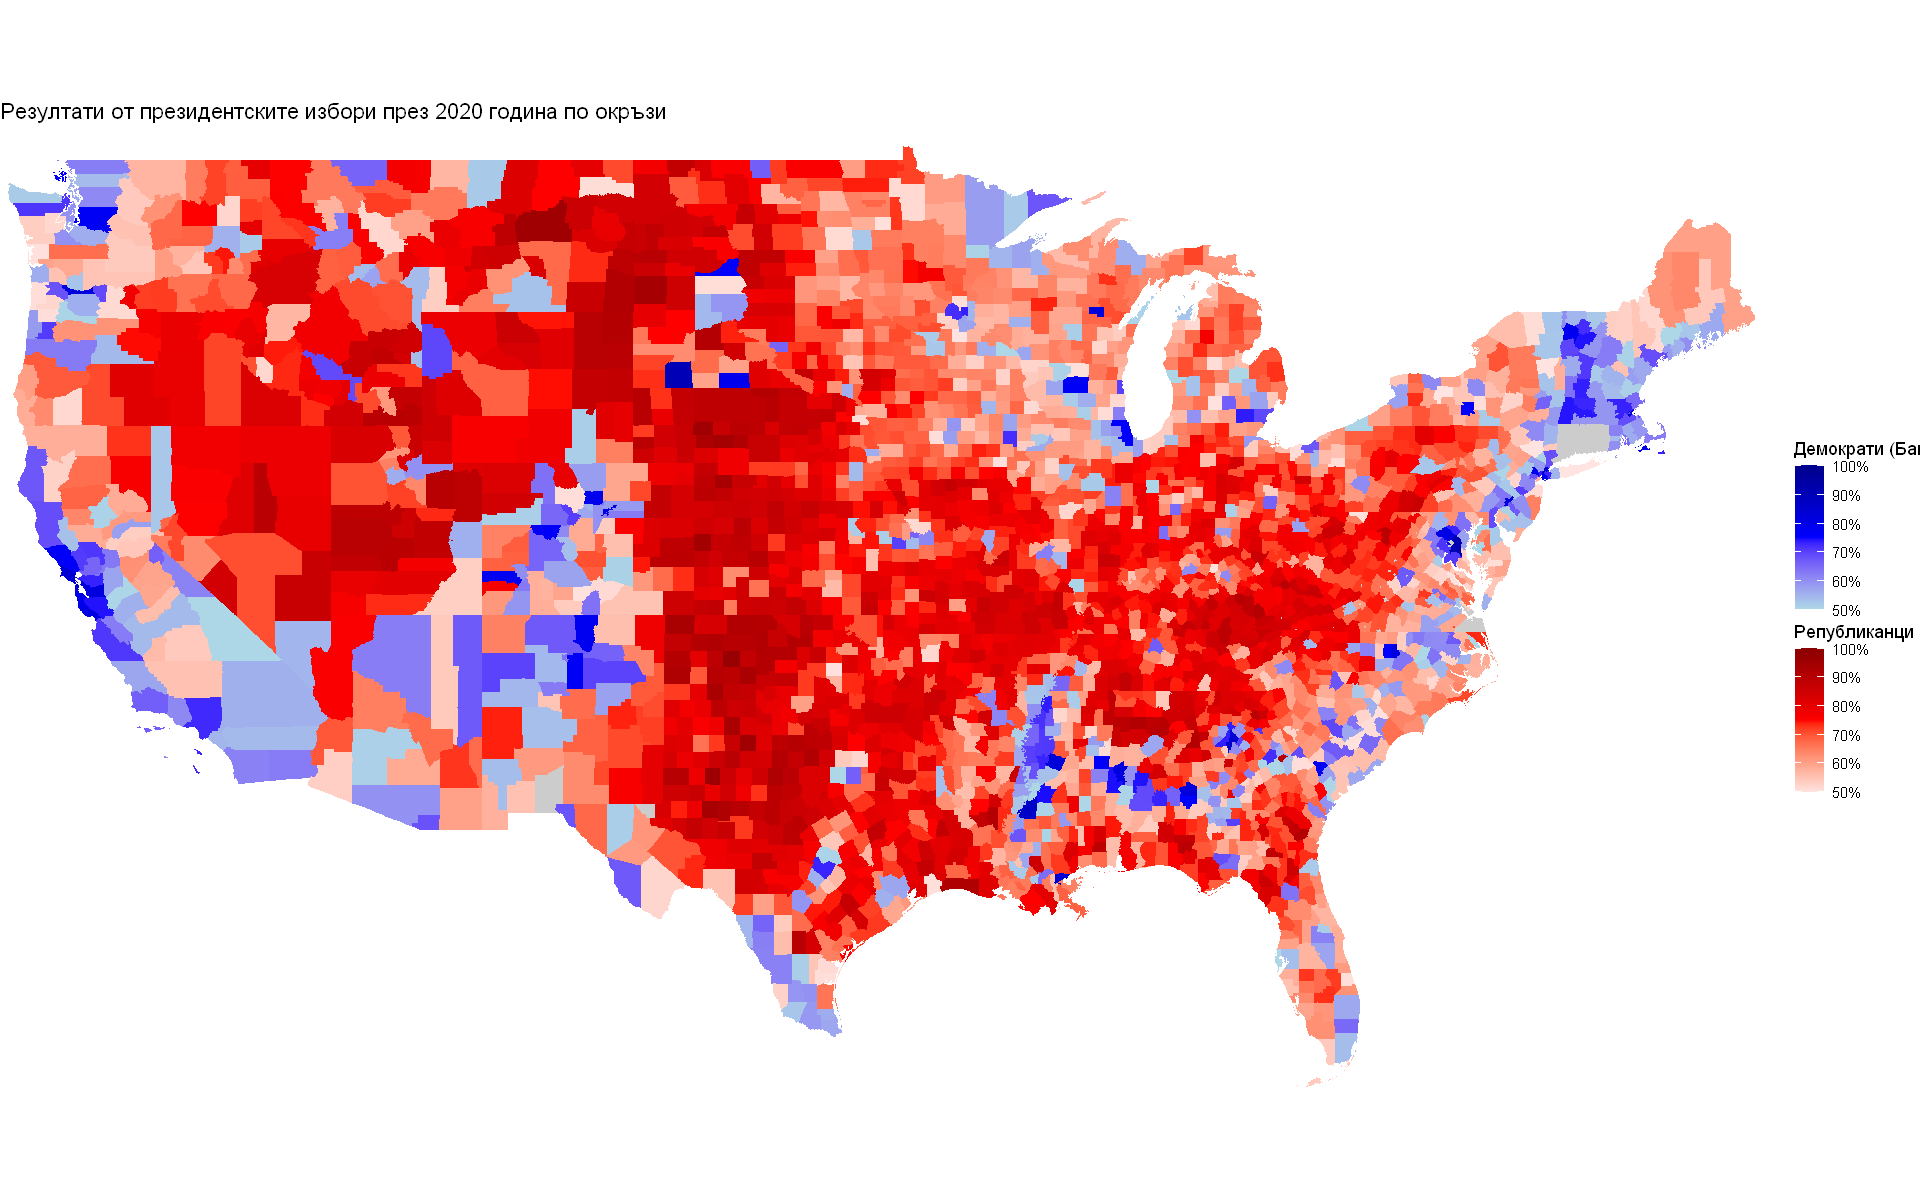

In [6]:
repl_data <- data %>%
  mutate(county = str_replace(county, " County", ""),
         state = str_trim(state)) %>%
  mutate(county = str_replace(county, " Parish", ""))

options(tigris_use_cache = TRUE)
counties_sf <- counties(cb = TRUE, class = "sf") %>%
  mutate(NAME = str_trim(NAME),
         STATE_NAME = str_trim(STATE_NAME))

map_data <- counties_sf %>%
  left_join(repl_data, by = c("NAME" = "county", "STATE_NAME" = "state"))

map_data <- map_data %>%
  mutate(
    dem_votes = as.numeric(`X2020.Democrat.vote..`),
    rep_votes = as.numeric(`X2020.Republican.vote..`),
    total_votes = dem_votes + rep_votes,
    winner = case_when(
      dem_votes > rep_votes ~ "Democrat",
      rep_votes > dem_votes ~ "Republican",
      TRUE ~ "Tie"
    ),
    vote_share = case_when(
      winner == "Democrat" ~ dem_votes / total_votes,
      winner == "Republican" ~ rep_votes / total_votes,
      TRUE ~ NA_real_
    )
  )

dem_gradient <- col_numeric(palette = c("lightblue", "blue", "darkblue"), domain = c(0.5, 1))
rep_gradient <- col_numeric(palette = c("mistyrose", "red", "darkred"), domain = c(0.5, 1))

map_data <- map_data %>%
  mutate(fill_color = case_when(
    winner == "Democrat" ~ dem_gradient(vote_share),
    winner == "Republican" ~ rep_gradient(vote_share),
    TRUE ~ "gray80"
  ))

dem_data <- map_data %>% filter(winner == "Democrat")
rep_data <- map_data %>% filter(winner == "Republican")
tie_data <- map_data %>% filter(winner == "Tie")

options(repr.plot.width = 16, repr.plot.height = 10)
ggplot() +
  geom_sf(data = dem_data, aes(fill = vote_share), color = NA) +
  scale_fill_gradientn(
    colors = c("lightblue", "blue", "darkblue"),
    limits = c(0.5, 1),
    name = "Демократи (Байдън) %",
    labels = percent_format(accuracy = 1)
  ) +
  new_scale_fill() +

  geom_sf(data = rep_data, aes(fill = vote_share), color = NA) +
  scale_fill_gradientn(
    colors = c("mistyrose", "red", "darkred"),
    limits = c(0.5, 1),
    name = "Републиканци (Тръмп) %",
    labels = percent_format(accuracy = 1)
  ) +
  new_scale_fill() +

  geom_sf(data = tie_data, fill = "gray80", color = NA) +

  coord_sf(xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE) +
  theme_void() +
  labs(title = "Резултати от президентските избори през 2020 година по окръзи")

## Анализ за outlier-и

Ще разглеждаме *outlier* като данна, която не попада между минимума и максимума в един boxplot. Даваме минимума като разликата на първия квартил и 1.5\*IQR, а максимума като сбора на третия квартил и 1.5\*IQR, където IQR - interquartile range (интерквартилен размах)

Изследваме за outlier-и процентът гласували за Джо Байдън и Доналд Тръмп през 2020 година:

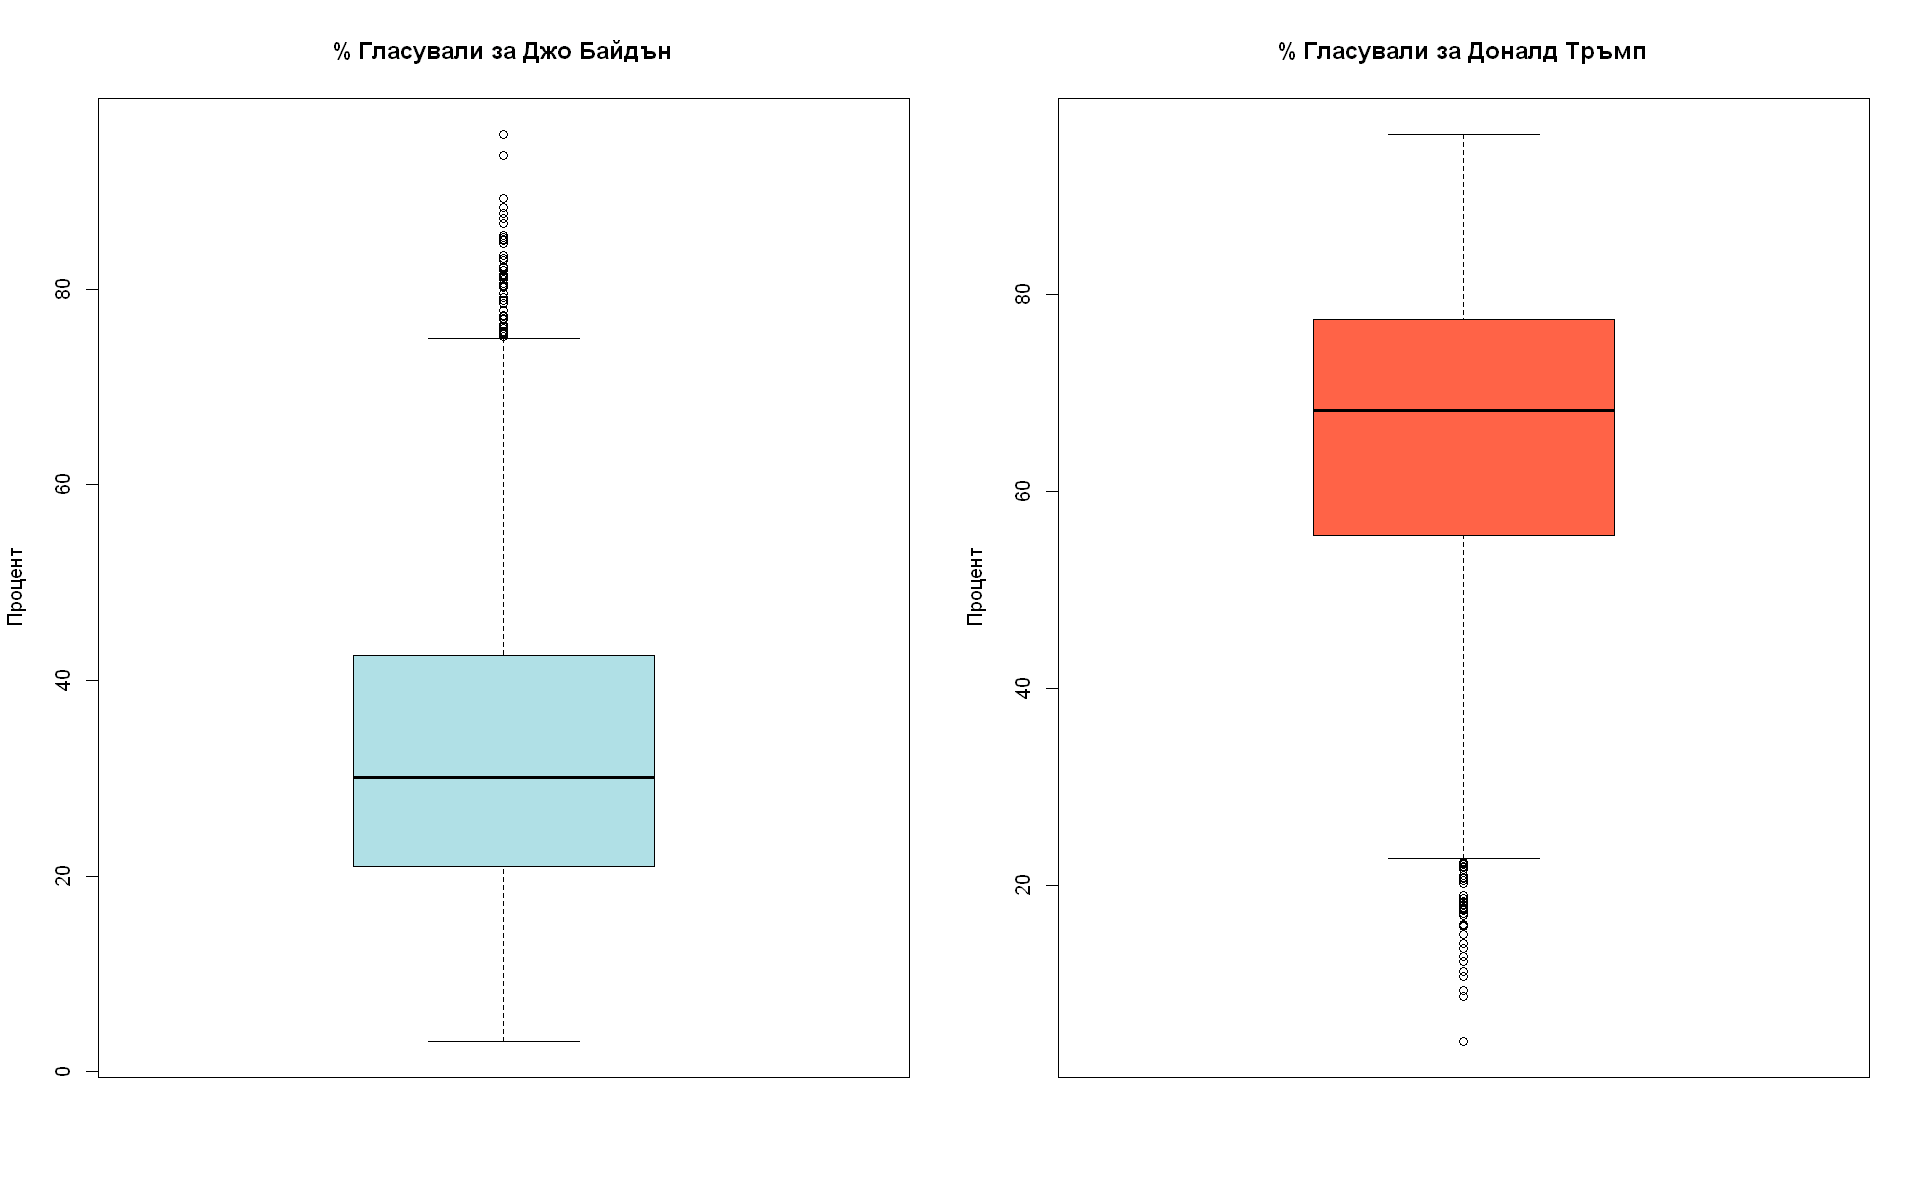

In [7]:
par(mfrow = c(1, 2))
boxplot(data$X2020.Democrat.vote.., col = "powderblue", main = "% Гласували за Джо Байдън", ylab = "Процент")
boxplot(data$X2020.Republican.vote.., col = "tomato", main = "% Гласували за Доналд Тръмп", 
        ylab = "Процент")
par(mfrow = c(1, 1))

Както се вижда, outlier-и има. Наличието на окръзи с толкова висок процент гласували за кандидат на Демократическата партия (над 70%), може да се обясни с това, че повечето от тези окръзи се намират в силно урбанизирани региони, в които населението е по-либерално настроено. </br>

Сега ще изследваме метриката за медиана на доходите по окръг. Тя е по-достоверна от тази за среден доход, тъй като outlier-ите в самото разпределение на доходите в даден окръг оказват по-голямо влияние на средната стойност, отколкото на медианата. Тоест, медианата е по-устойчива при наличие на outlier-и.

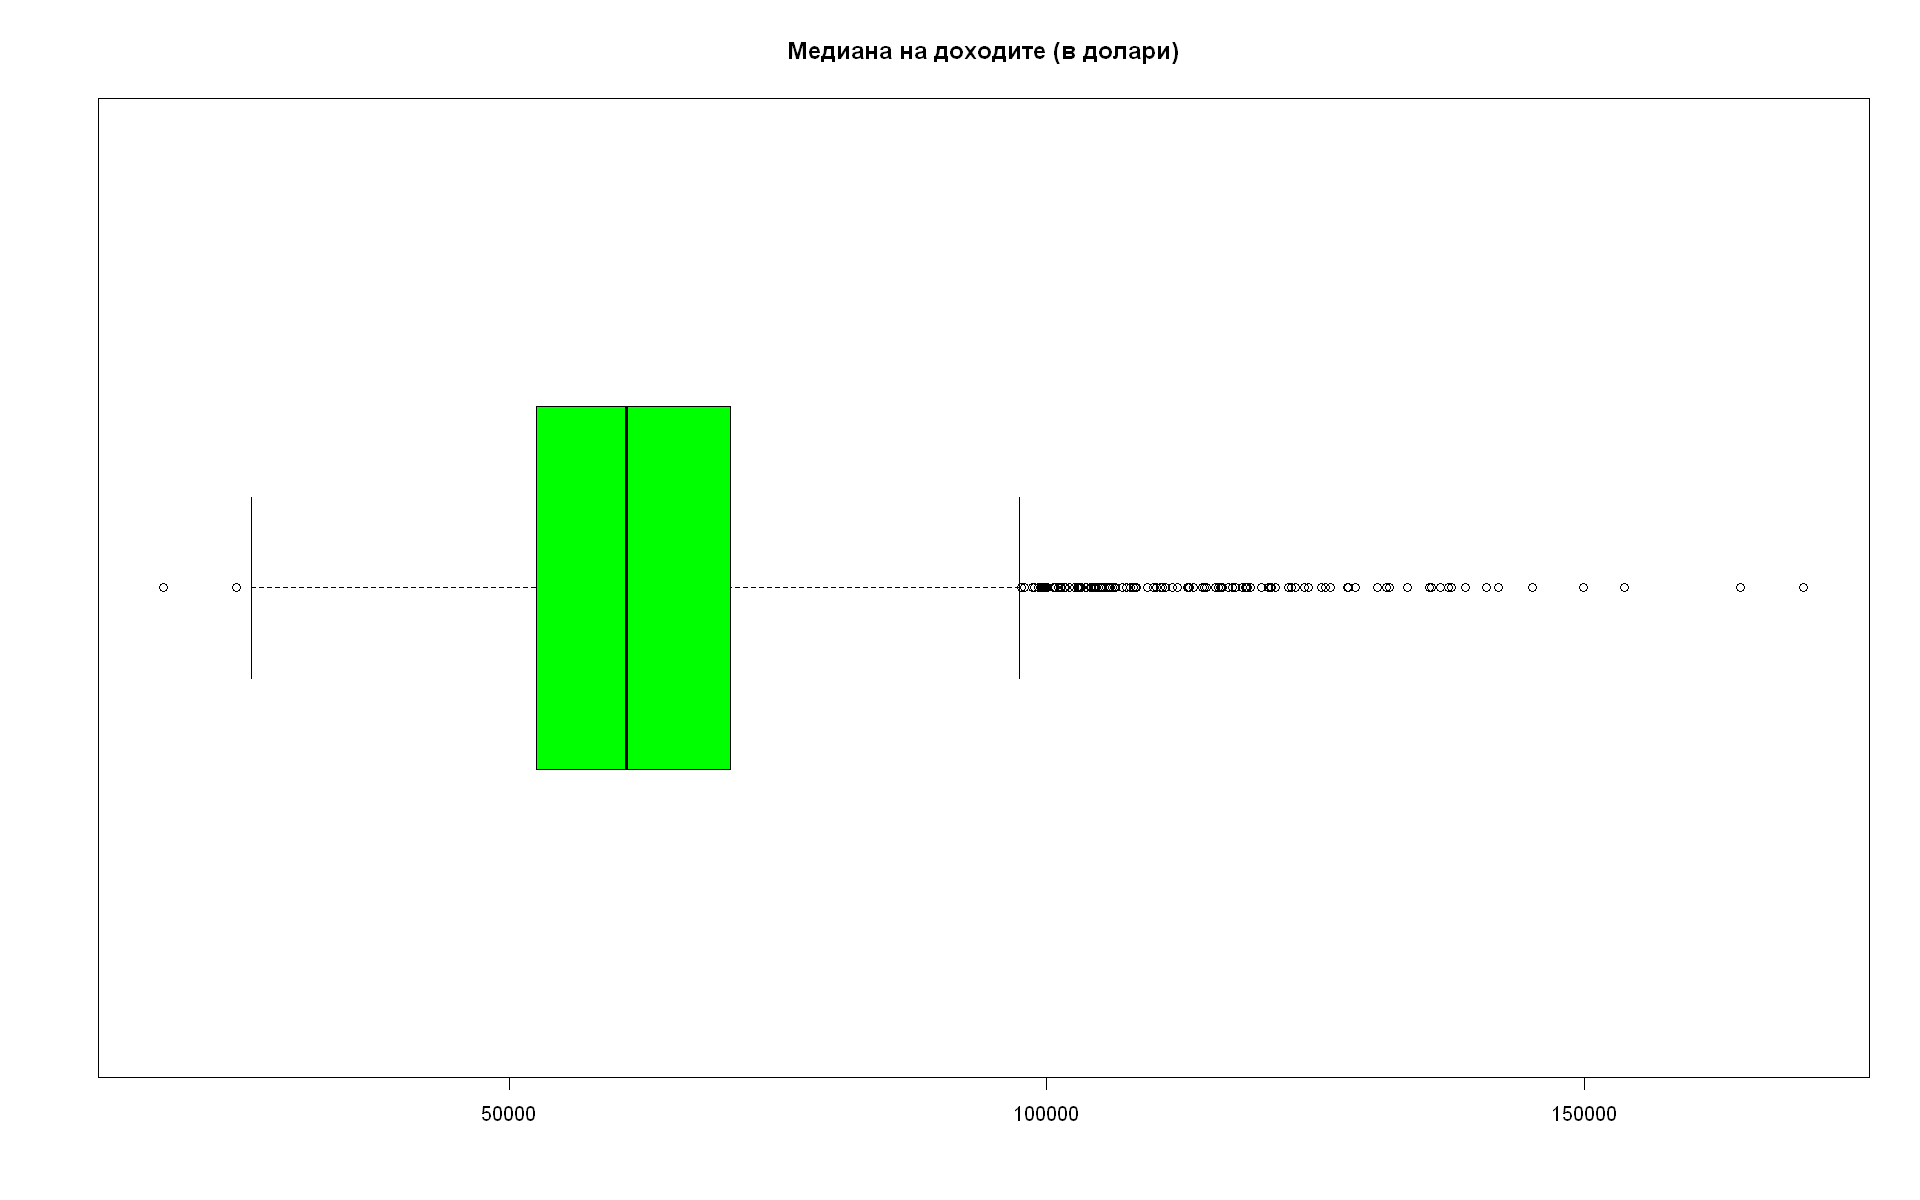

In [8]:
boxplot(data$Median.income..dollars., horizontal = T, col = "green", main = "Медиана на доходите (в долари)")

Както се вижда, и тук има outlier-и. Те са именно окръзите около Окръг Колумбия (D.C.), в които се намират много правителствени учреждения. </br> Нека тестваме за outlier-и също и населението на окръзите:

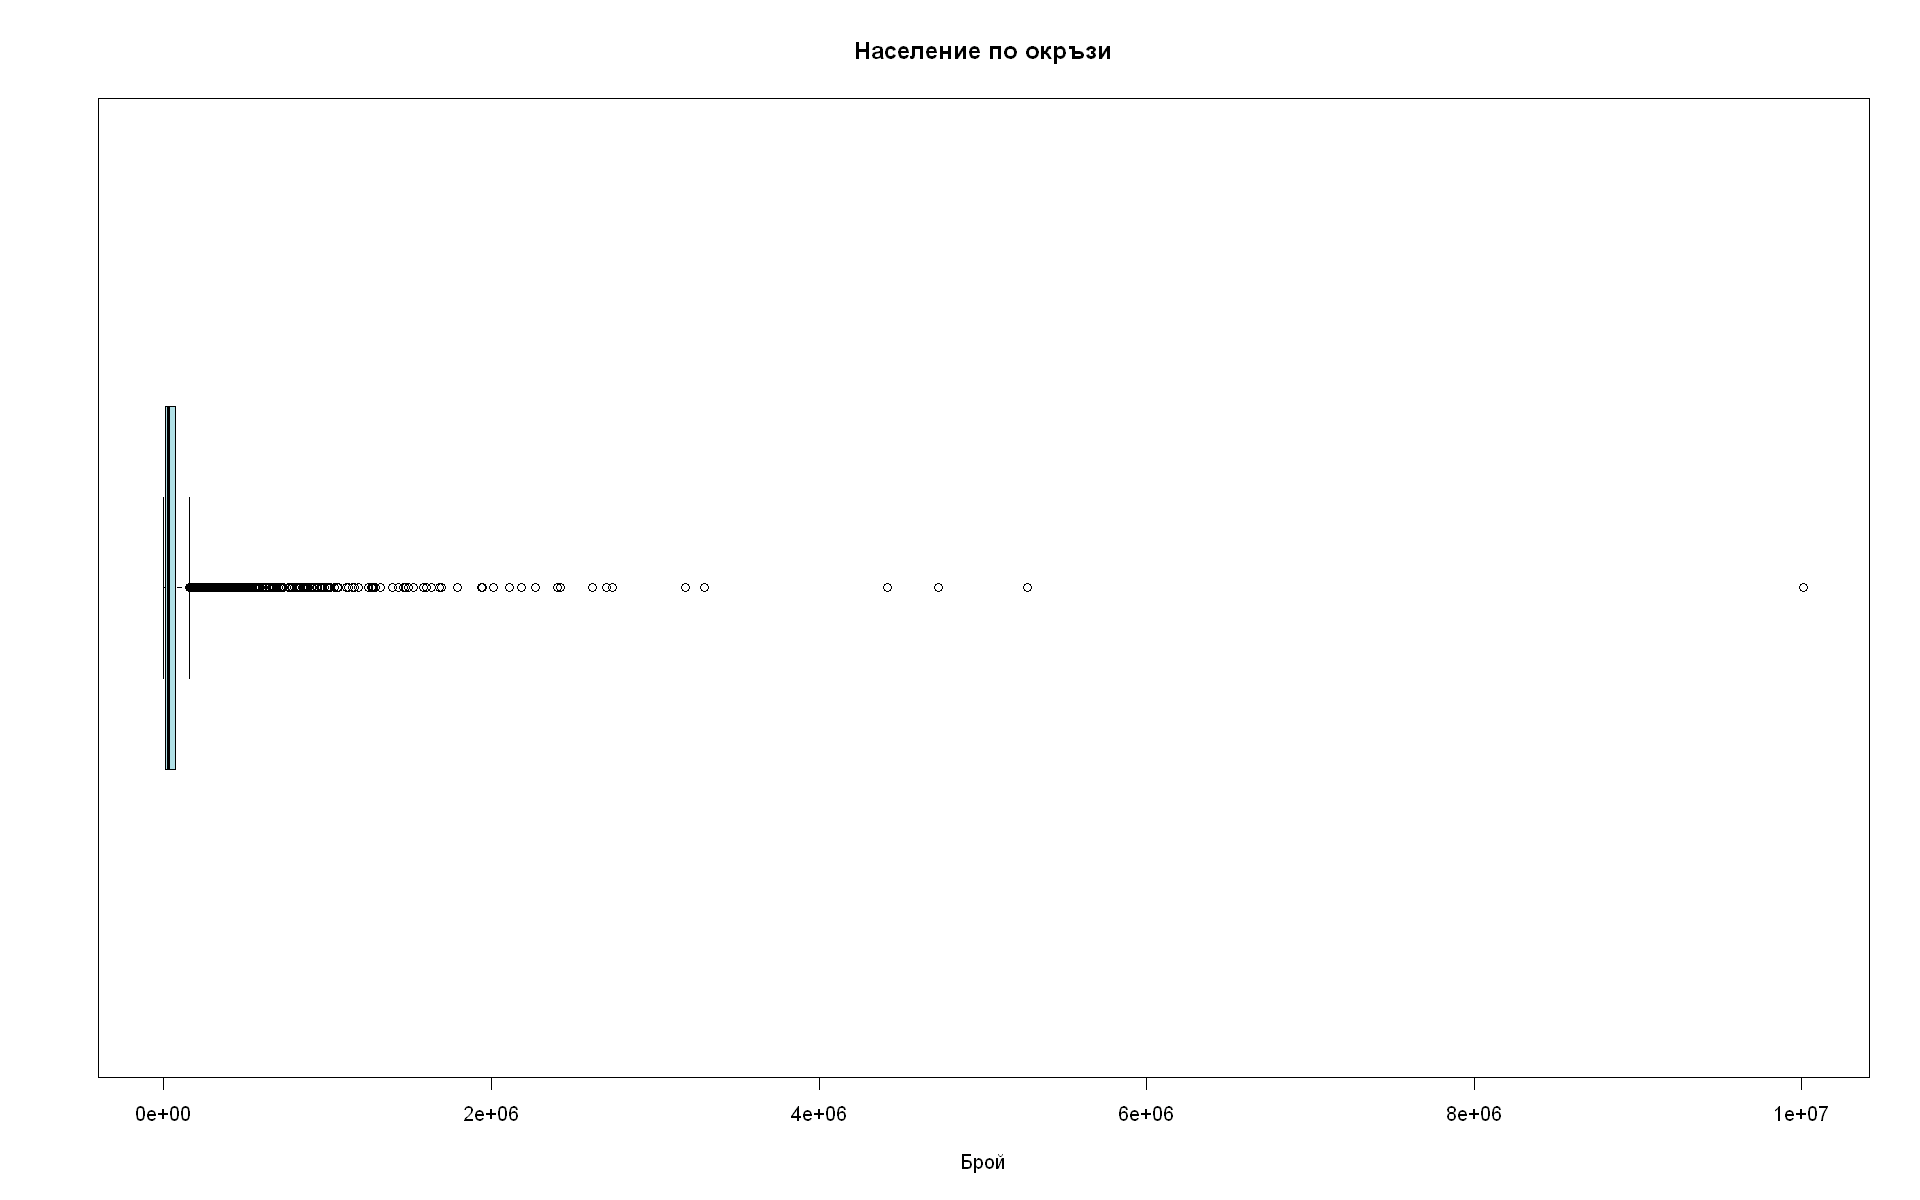

In [9]:
boxplot(data$Total.Population, horizontal = T, col = "powderblue", main = "Население по окръзи", xlab = "Брой")

Тук очевидно outlier-ите са много и това е така, поради факта, че по-големите метрополиси се разделят на много окръзи, но не винаги - има поне 4 интересни примера:
- цялата Los Angeles Metropolitan Area е обединена в един окръг с население над 10 милиона души (Los Angeles County)
- Чикаго е обединен в един окръг с население над 5 милиона души (Cook County)
- Хюстън е обединен в един окръг с население над 4.5 милиона души (Harris County)
- Финикс е обединен в един окръг с население над 4 милиона души (Maricopa County)

Последно, нека изследваме етническите показатели за outlier-и:

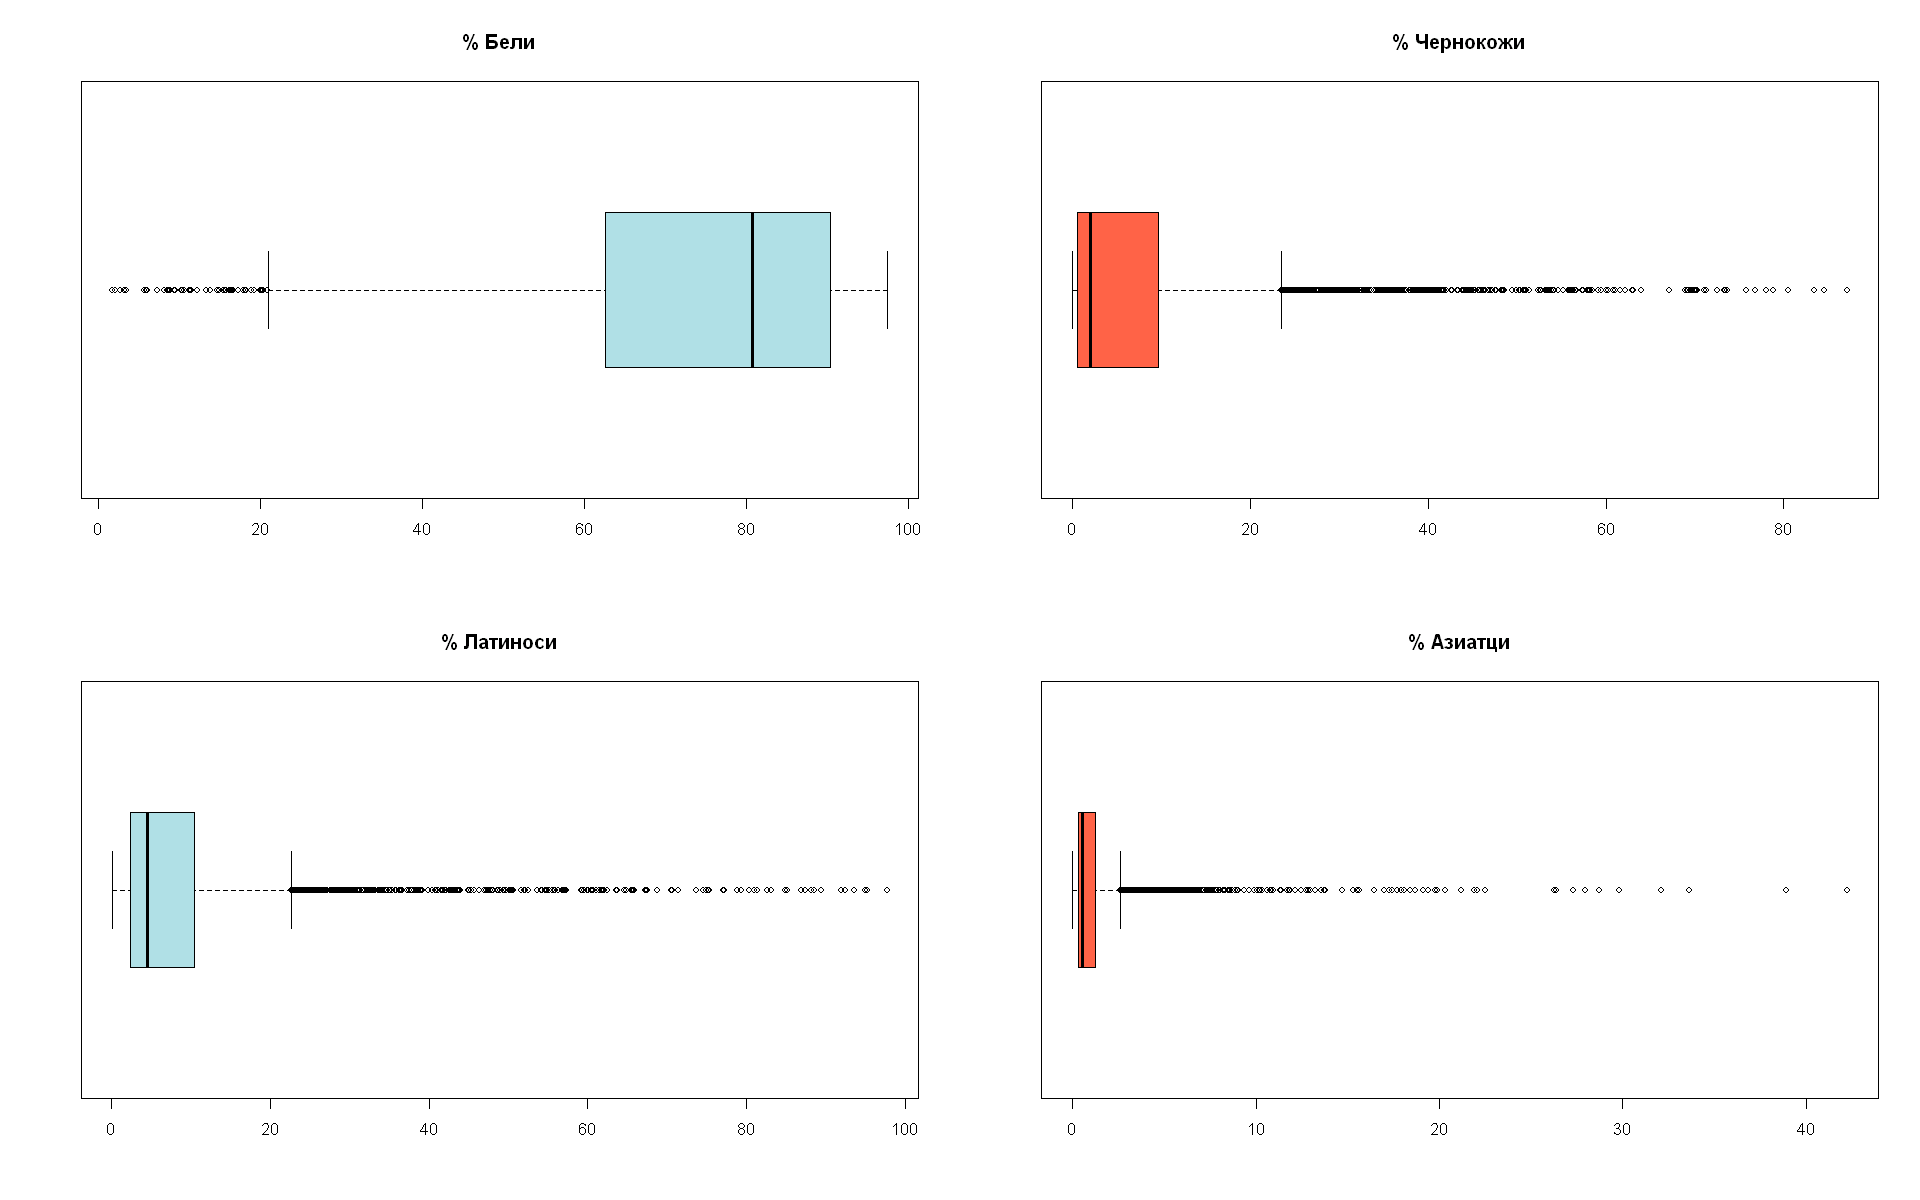

In [10]:
par(mfrow = c(2, 2))
boxplot(data$NH.White.percentage, horizontal = T, col = "powderblue", main = "% Бели")
boxplot(data$NH.Black.percentage, horizontal = T, col = "tomato", main = "% Чернокожи")
boxplot(data$Hispanic.or.Latino.percentage, horizontal = T, col = "powderblue", main = "% Латиноси")
boxplot(data$NH.Asian.percentage, horizontal = T, col = "tomato", main = "% Азиатци")
par(mfrow = c(1, 1))

Вижда се, че има връзка между процента бели в даден окръг и сборът от процентите на останалите групи - тази връзка ще проучим подробно по-надолу. Outlier-ите, показващи високи проценти чернокожи (70% и нагоре) са от сравнително слабо населени окръзи в южната част на САЩ (най-вече тези по поречието на река Мисисипи). Outlier-ите спрямо азиатското население са в окръзи като Хонолулу, Санта Клара и Сан Франциско, които са известни с многобройната си азиатска диаспора, а Outlier-ите спрямо латиносите са почти винаги окръзи на границата с Мексико, които по разбираеми причини имат доста висок процент (над 80-85%) латино население.

## Многомерен анализ и изследване на зависимости
Идеята тук е следната:
- ще разгледаме графики (scatterplots) и карти, за да видим графично връзки между различни променливи
- ще направим тестове за нормалност на променливите, които ще използваме, за да знаем какви точно тестове за статистическа значимост и връзка да използваме
- ще направим тестове за статистическа зависимост

### Графично сравнение
Ще направим 3 по-очевидни сравнения за връзка между 2 променливи:
- процент гласували за Тръмп срещу процент гласували за Байдън
- процент жители с бакалавърска степен срещу медиана на доходите
- процент жители без основно образование срещу коефициента на Джини

`geom_smooth()` using formula = 'y ~ x'


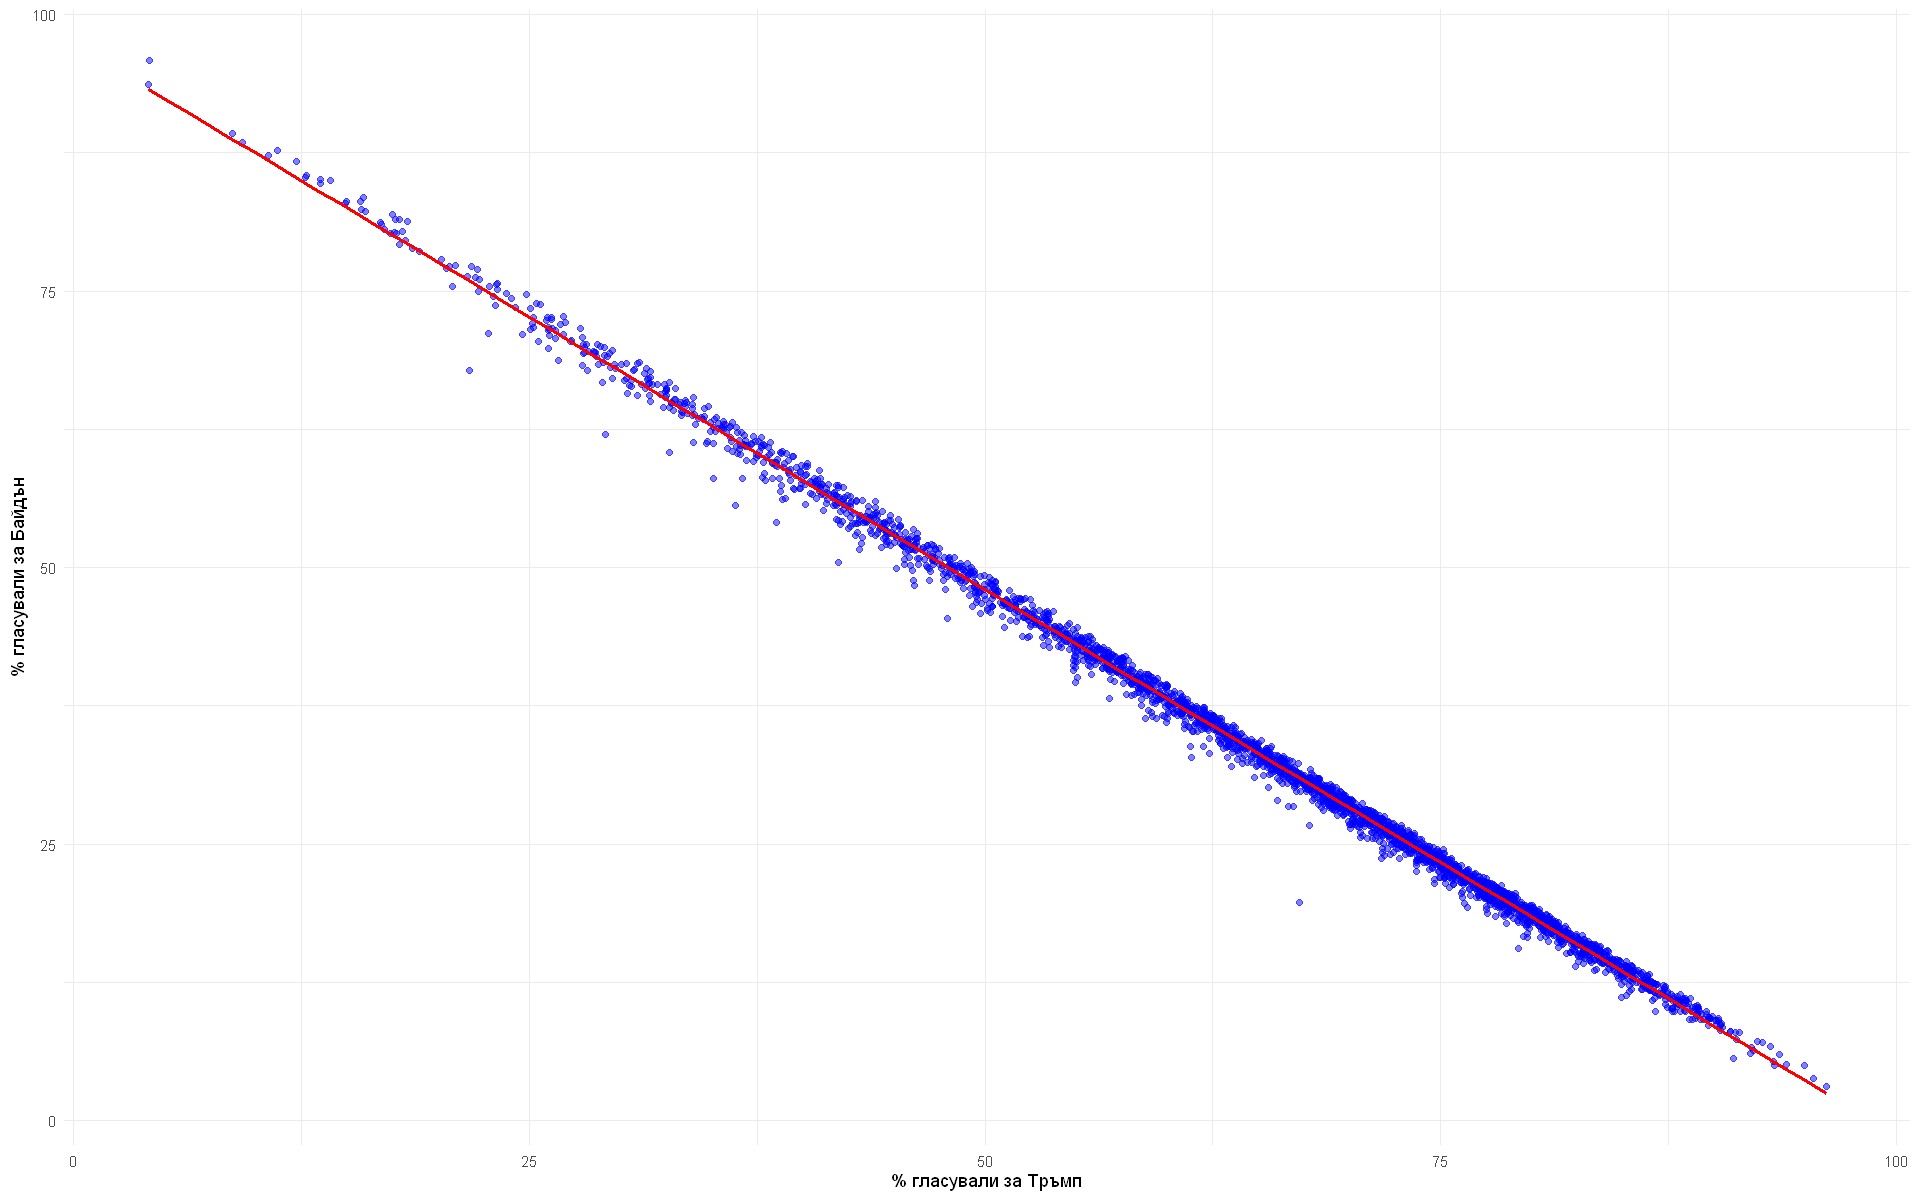

In [11]:
ggplot(data, aes(x = X2020.Republican.vote.., y = X2020.Democrat.vote..)) + 
    geom_point(alpha = 0.5, color = "blue") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(x = "% гласували за Тръмп", y = "% гласували за Байдън") + 
    theme_minimal()


Напълно очевидно, колкото по-голям процент хора гласуват за Тръмп, толкова по-малък процент хора гласуват за Байдън и обратното

`geom_smooth()` using formula = 'y ~ x'


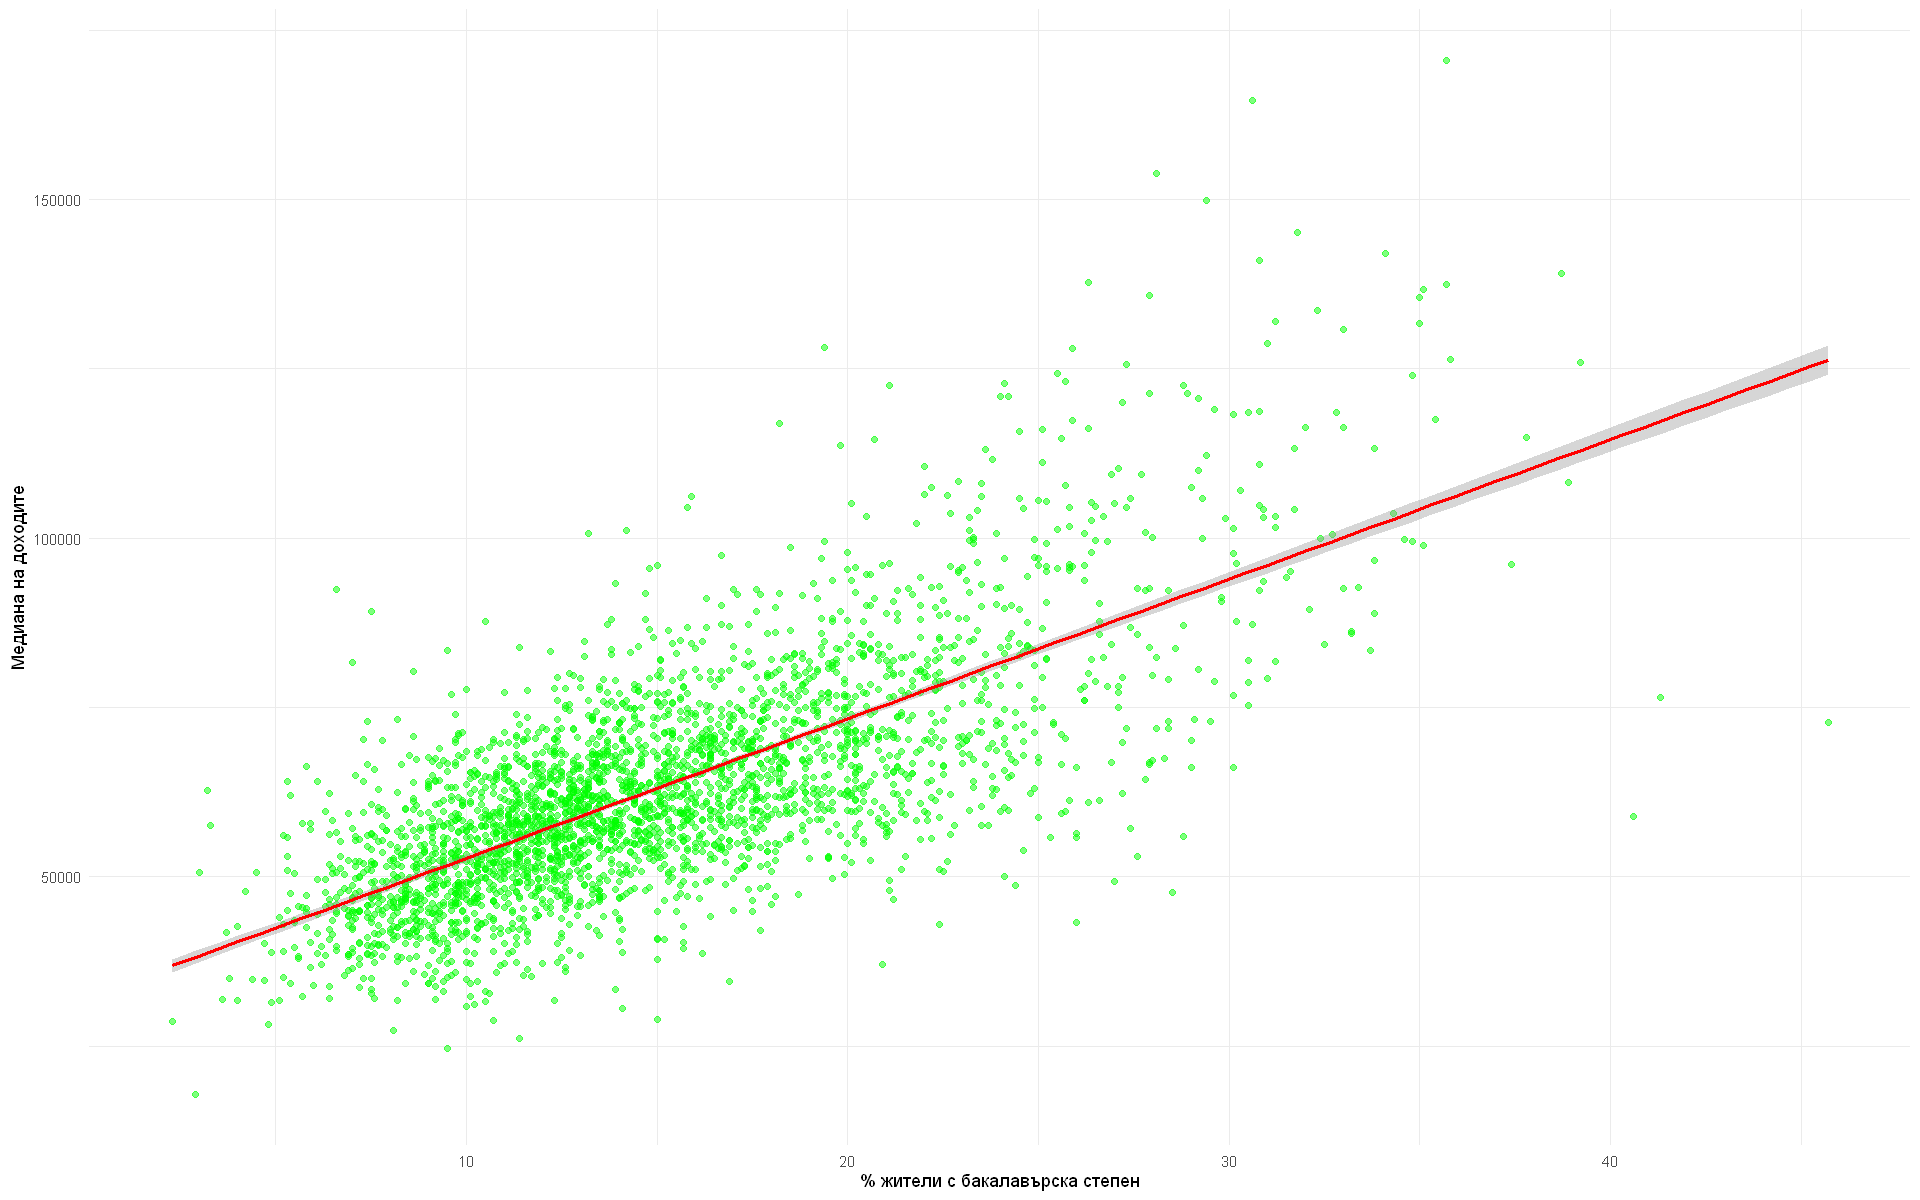

In [12]:
ggplot(data, aes(x = Bachelors.Degree, y = Median.income..dollars.)) + 
    geom_point(alpha = 0.5, color = "green") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(x = "% жители с бакалавърска степен", y = "Медиана на доходите") + 
    theme_minimal()

Тук логично, с повишаването на процента хора с висше образование, се покачват и доходите на дадения окръг.

`geom_smooth()` using formula = 'y ~ x'


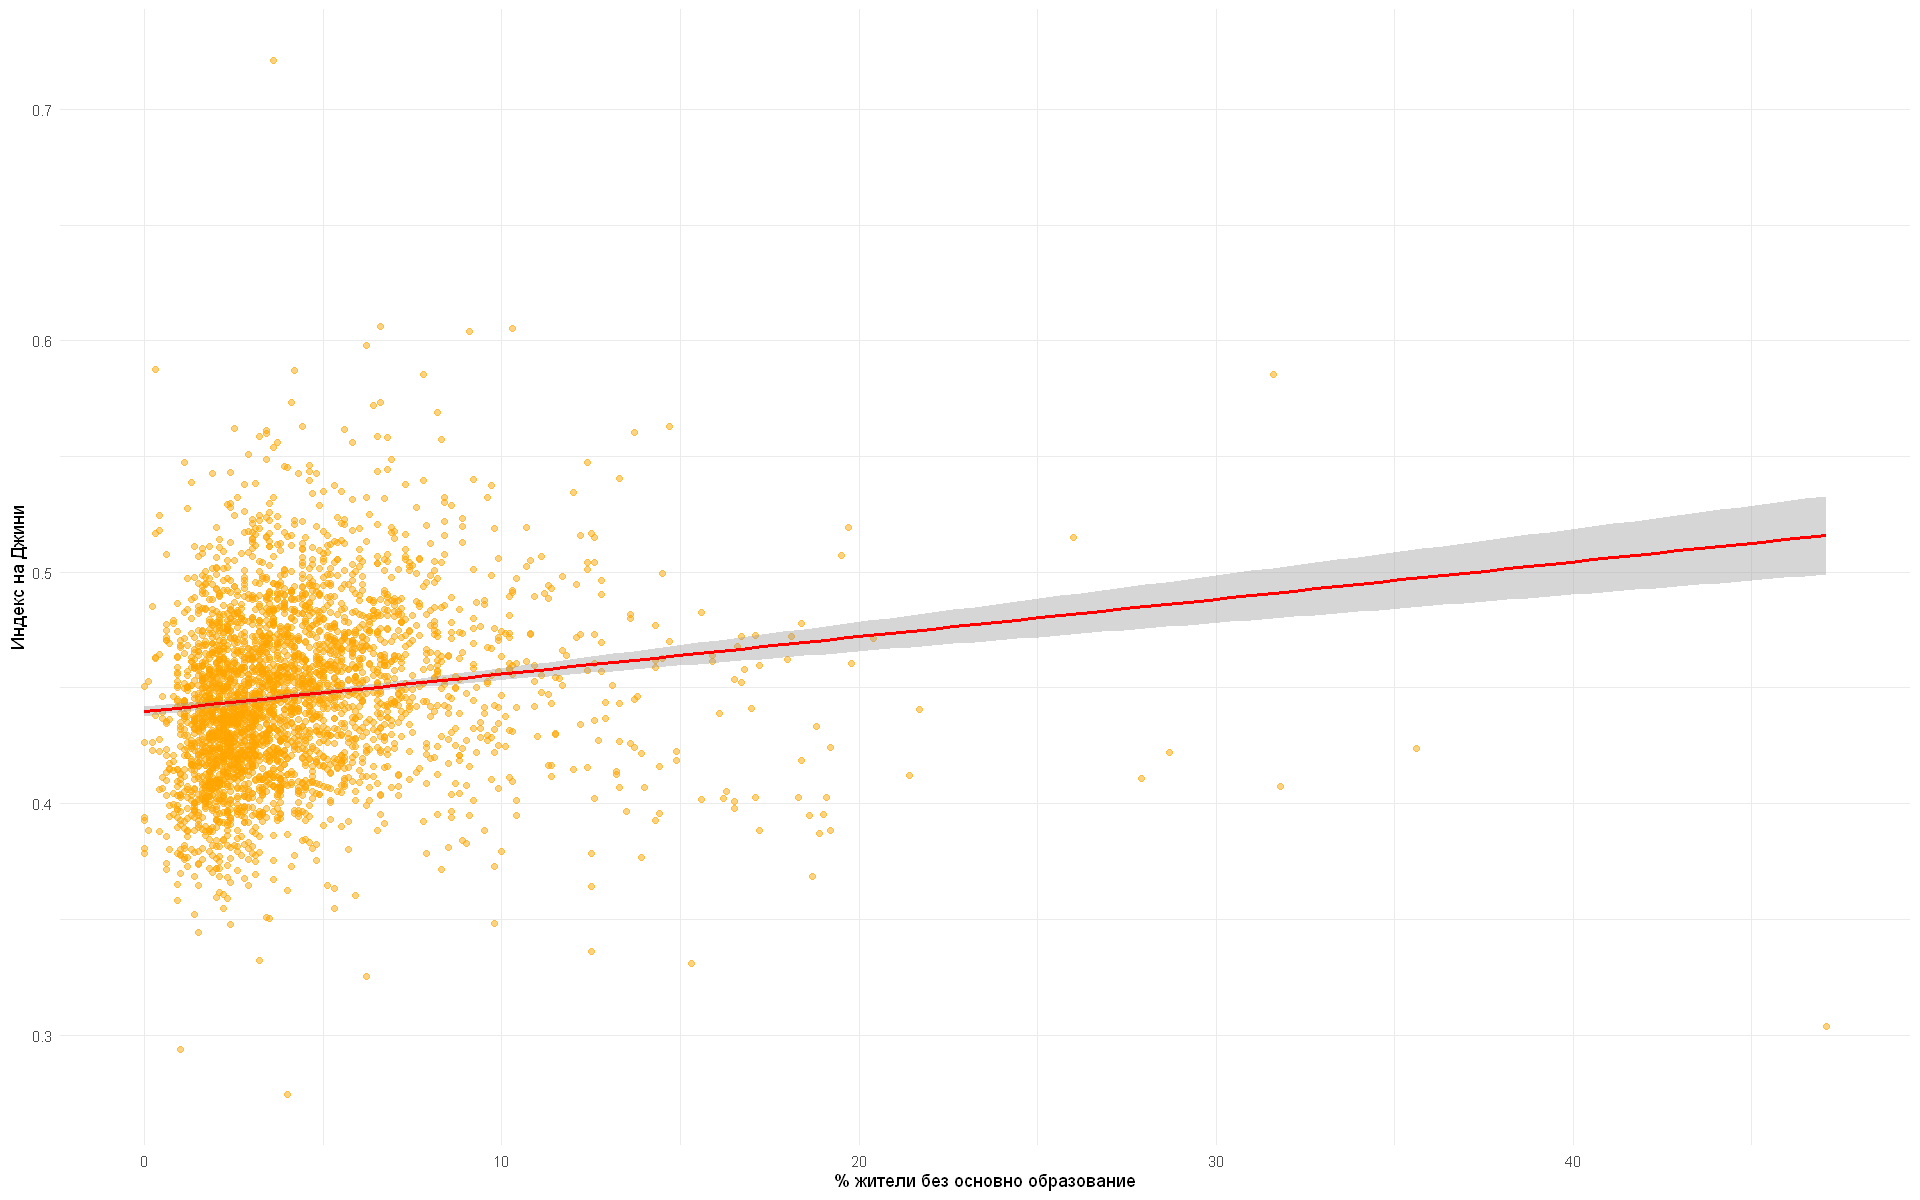

In [13]:
ggplot(data, aes(x = Population.with.less.than.9th.grade.education, y = Gini.Index)) + 
    geom_point(alpha = 0.5, color = "orange") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(x = "% жители без основно образование", y = "Индекс на Джини") + 
    theme_minimal()

Тук виждаме, че коефициентът на Джини не зависи особено от процентът жители без основно образование, но въпреки това трендът е, че с увеличаването на този процент се увеличава и коефициентът на Джини (тоест се увеличава неравенството в доходите на даден окръг) </br>

Ясно е, че тези връзки няма да ни помогнат особено при определянето на факторите, тъй като те са очевидни. Нека разгледаме няколко двойки променливи, които биха ни помогнали да направим модела за предсказване. Понеже САЩ е държава с де факто двупартийна система е почти същото дали ще анализираме резултатите на Демократите или на Републиканците.

#### Расово-етнически анализ
Разглеждаме за връзки следните двойки:
- процент гласували за Демократите срещу процента бели
- процент гласували за Републиканците срещу сумата от проценти на малцинствата (всички, които не са бели)
- процент гласували за Демократите срещу процента чернокожи
- процент гласували за Демократите срещу процента латиноси

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


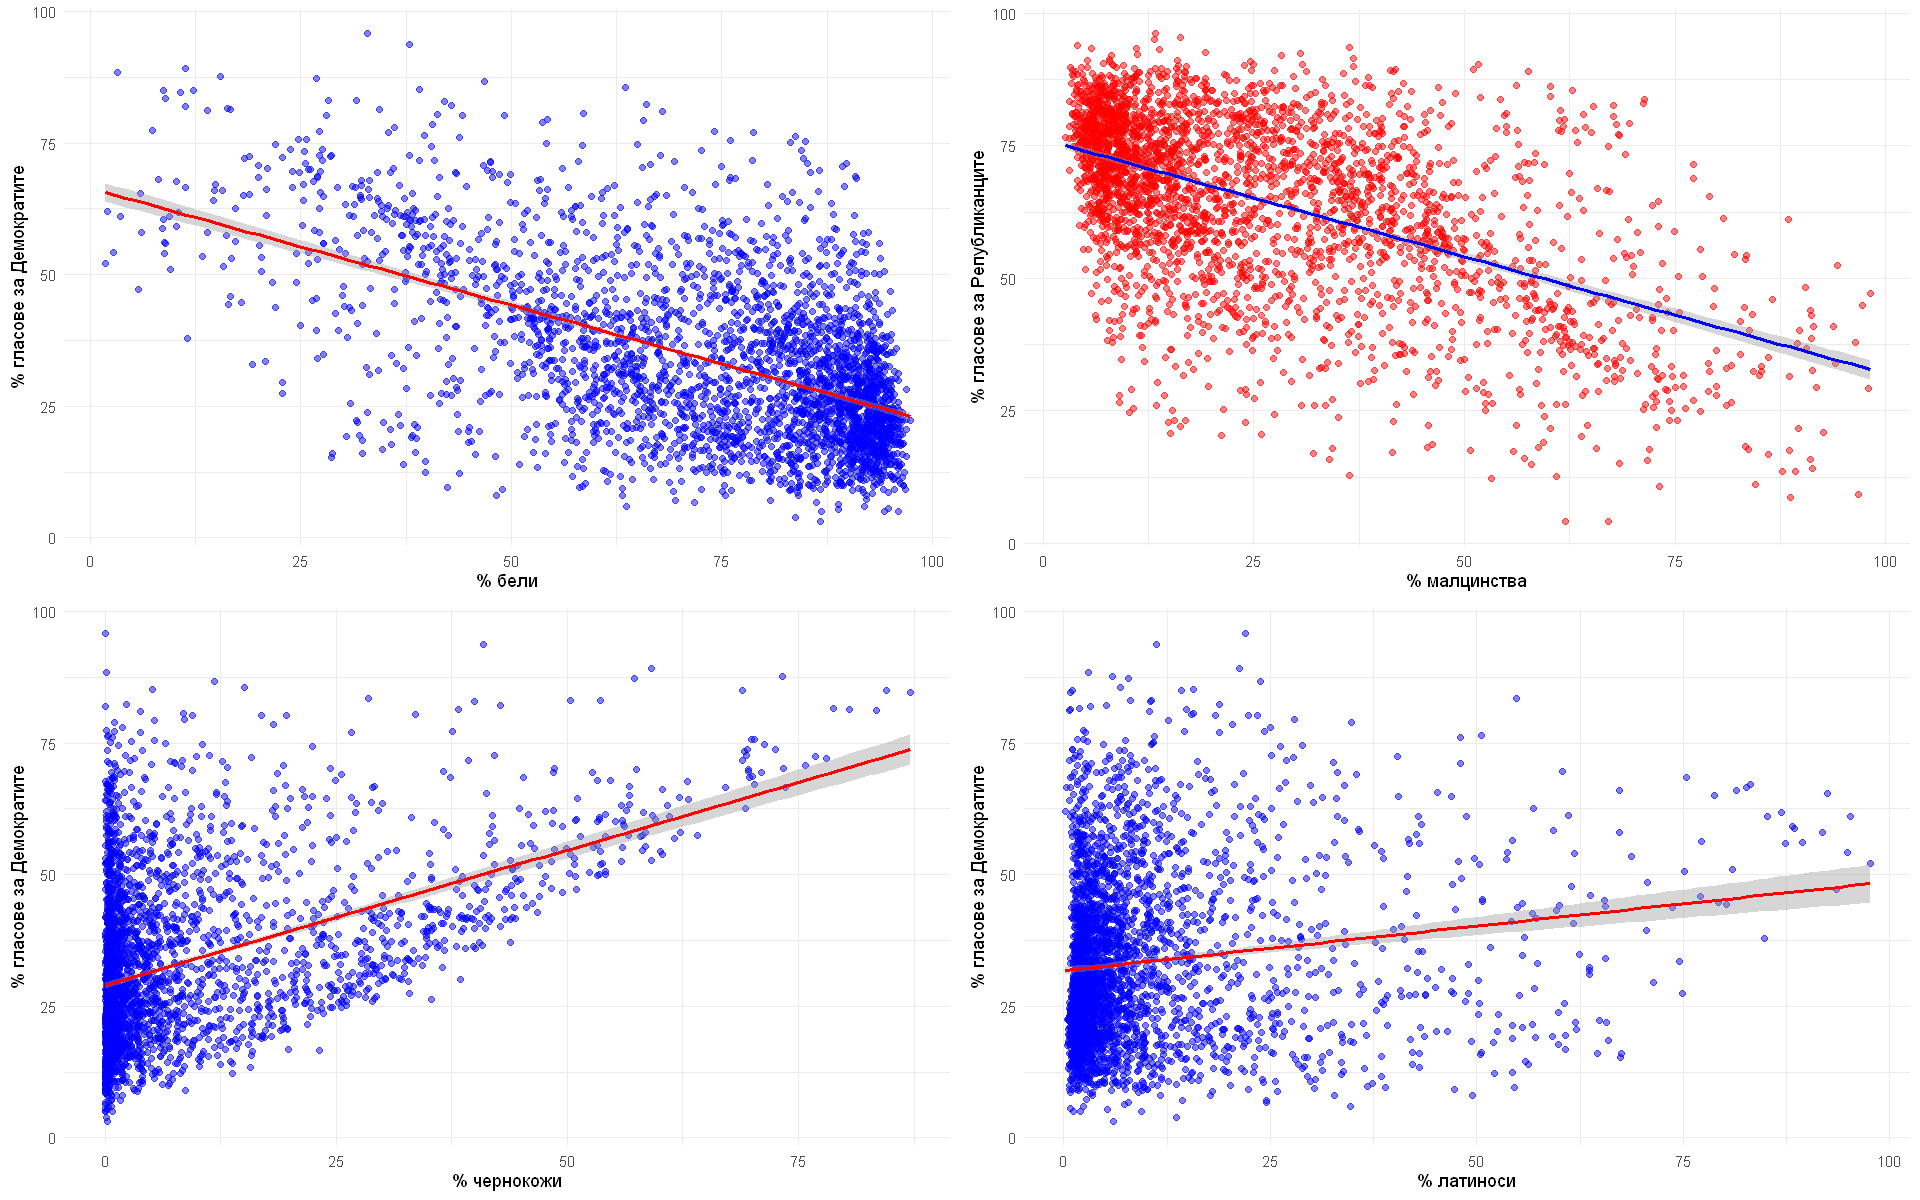

In [14]:
white_dem <- ggplot(data, aes(x = NH.White.percentage, y = X2020.Democrat.vote..)) + 
    geom_point(alpha = 0.5, color = "blue") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(x = "% бели", y = "% гласове за Демократите") + 
    theme_minimal()
minorities_rep <- ggplot(data, aes(x = 100 - NH.White.percentage, y = X2020.Republican.vote..)) + 
    geom_point(alpha = 0.5, color = "red") +
    geom_smooth(method = "lm", color = "blue", se = TRUE) +
    labs(x = "% малцинства", y = "% гласове за Републиканците") + 
    theme_minimal()
afam_dem <- ggplot(data, aes(x = NH.Black.percentage, y = X2020.Democrat.vote..)) + 
    geom_point(alpha = 0.5, color = "blue") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(x = "% чернокожи", y = "% гласове за Демократите") + 
    theme_minimal()
latino_dem <- ggplot(data, aes(x = Hispanic.or.Latino.percentage, y = X2020.Democrat.vote..)) + 
    geom_point(alpha = 0.5, color = "blue") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(x = "% латиноси", y = "% гласове за Демократите") + 
    theme_minimal()
grid.arrange(white_dem, minorities_rep, afam_dem, latino_dem, nrow=2, ncol=2, widths = c(1, 1))

Забелязва се, че колкото по-нисък става процентът бели в даден окръг (и съответно колкото по-висок става процентът малцинства), толкова по-висок резултат отбелязват Демократите. </br>
Тези наблюдения се потвърждават и от хороплетните карти по-долу: 

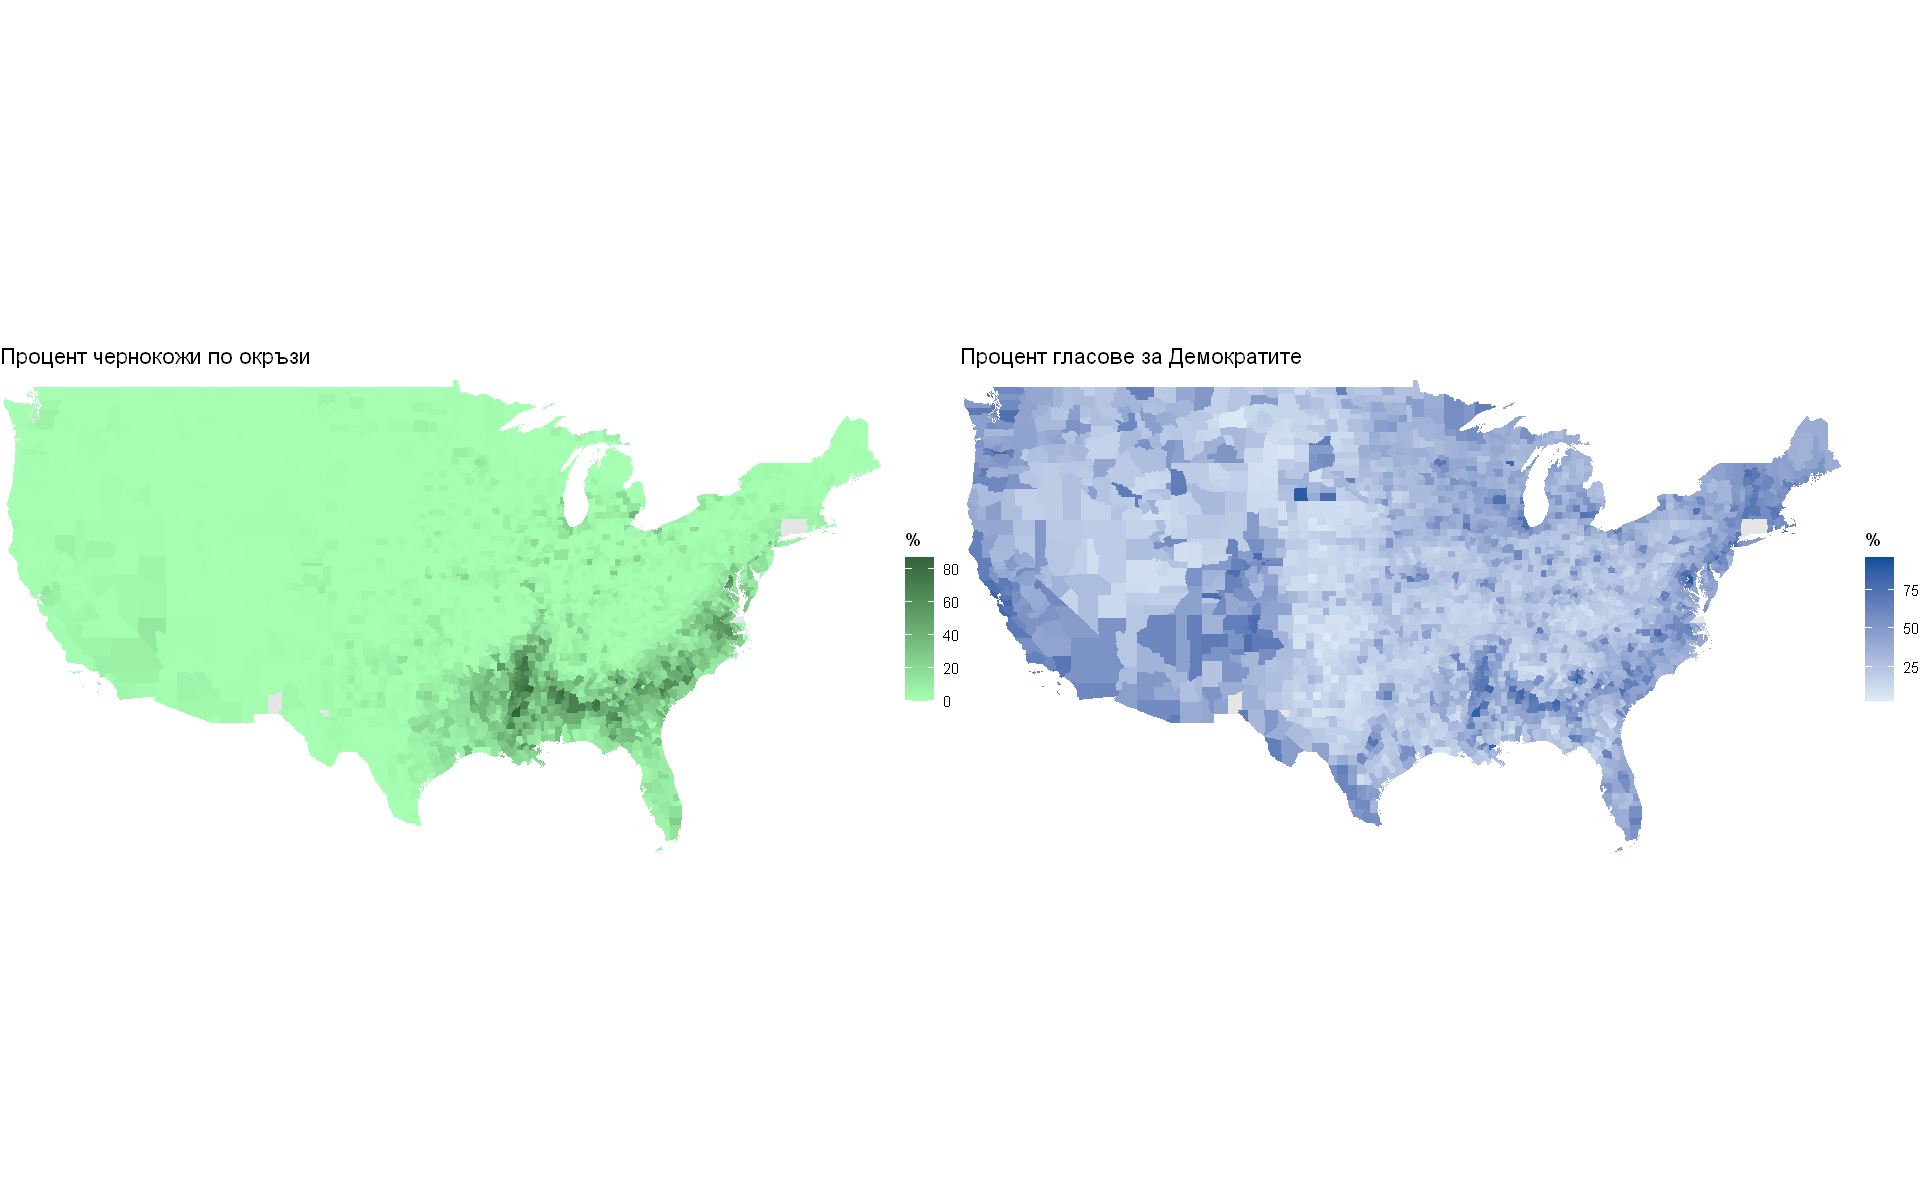

In [15]:
options(repr.plot.width = 16, repr.plot.height = 10)
afam_per <- ggplot(map_data) +
  geom_sf(aes(fill = NH.Black.percentage), color = NA) +
  scale_fill_gradient(
    low = "#a6ffb2",   # light blue
    high = "#34633a",  # dark blue
    na.value = "gray90",
    name = "%"
  ) +
  coord_sf(xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE) +
  theme_void() +
  labs(title = "Процент чернокожи по окръзи")
dems_per <- ggplot(map_data) +
  geom_sf(aes(fill = X2020.Democrat.vote..), color = NA) +
  scale_fill_gradient(
    low = "#deebf7",  
    high = "#08519c", 
    na.value = "gray90",
    name = "%"
  ) +
  coord_sf(xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE) +
  theme_void() +
  labs(title = "Процент гласове за Демократите")
reps_per <- ggplot(map_data) +
  geom_sf(aes(fill = X2020.Republican.vote..), color = NA) +
  scale_fill_gradient(
    low = "#ffe6e6",  
    high = "#ab0202",  
    na.value = "gray90",
    name = "%"
  ) +
  coord_sf(xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE) +
  theme_void() +
  labs(title = "Процент гласове за Републиканците")
grid.arrange(afam_per, dems_per, ncol=2, widths = c(1, 1))

Тук се вижда много голямо съотвествие между процента чернокожи и процента гласове за Демократите.

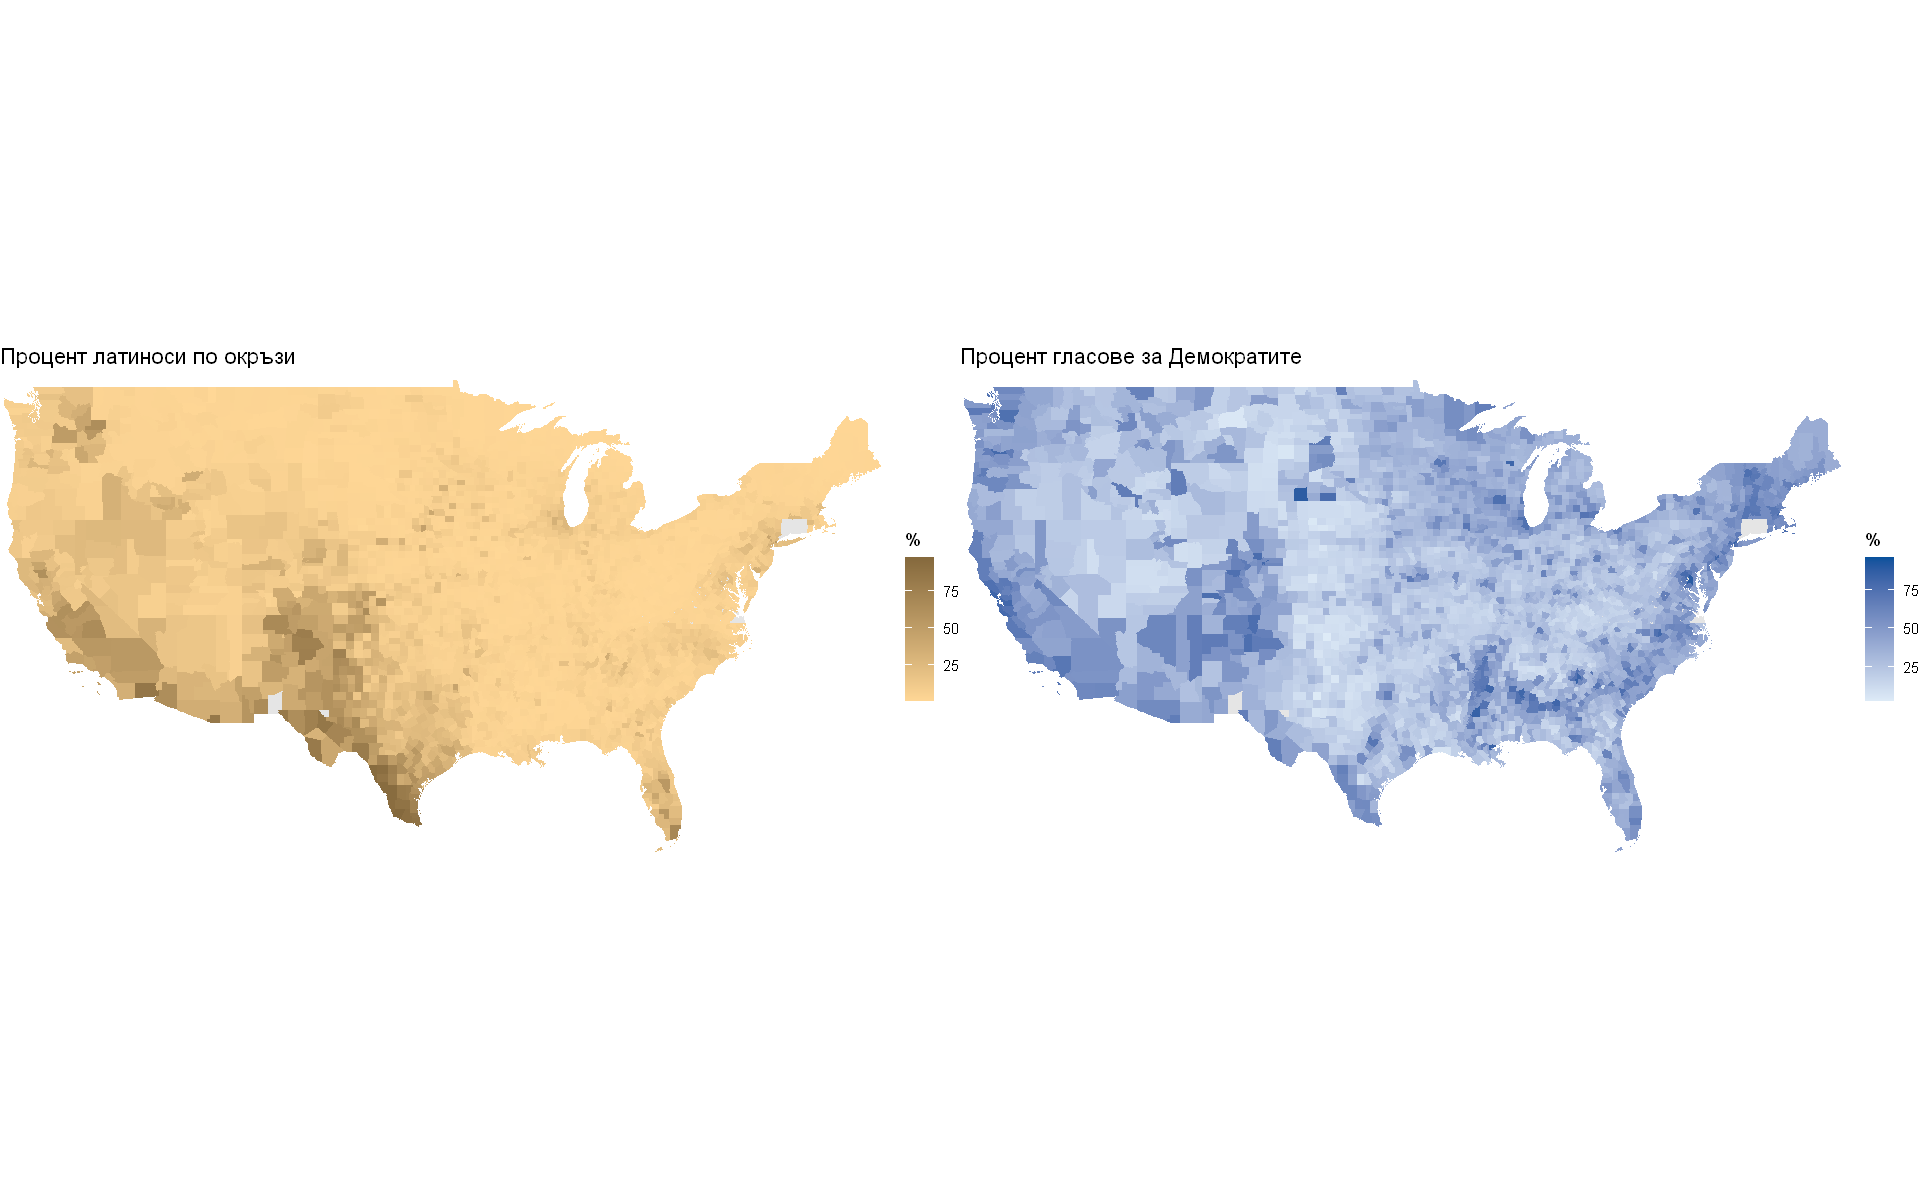

In [16]:
options(repr.plot.width = 16, repr.plot.height = 10)
latino_per <- ggplot(map_data) +
  geom_sf(aes(fill = Hispanic.or.Latino.percentage), color = NA) +
  scale_fill_gradient(
    low = "#ffd796",   
    high = "#85693d",  
    na.value = "gray90",
    name = "%"
  ) +
  coord_sf(xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE) +
  theme_void() +
  labs(title = "Процент латиноси по окръзи")
grid.arrange(latino_per, dems_per, ncol=2, widths = c(1, 1))

Забелязва се и, че Демократите имат силни позиции в окръзи с висок процент латиноси (най-вече тези по границата с Мексико и в щата Колорадо)

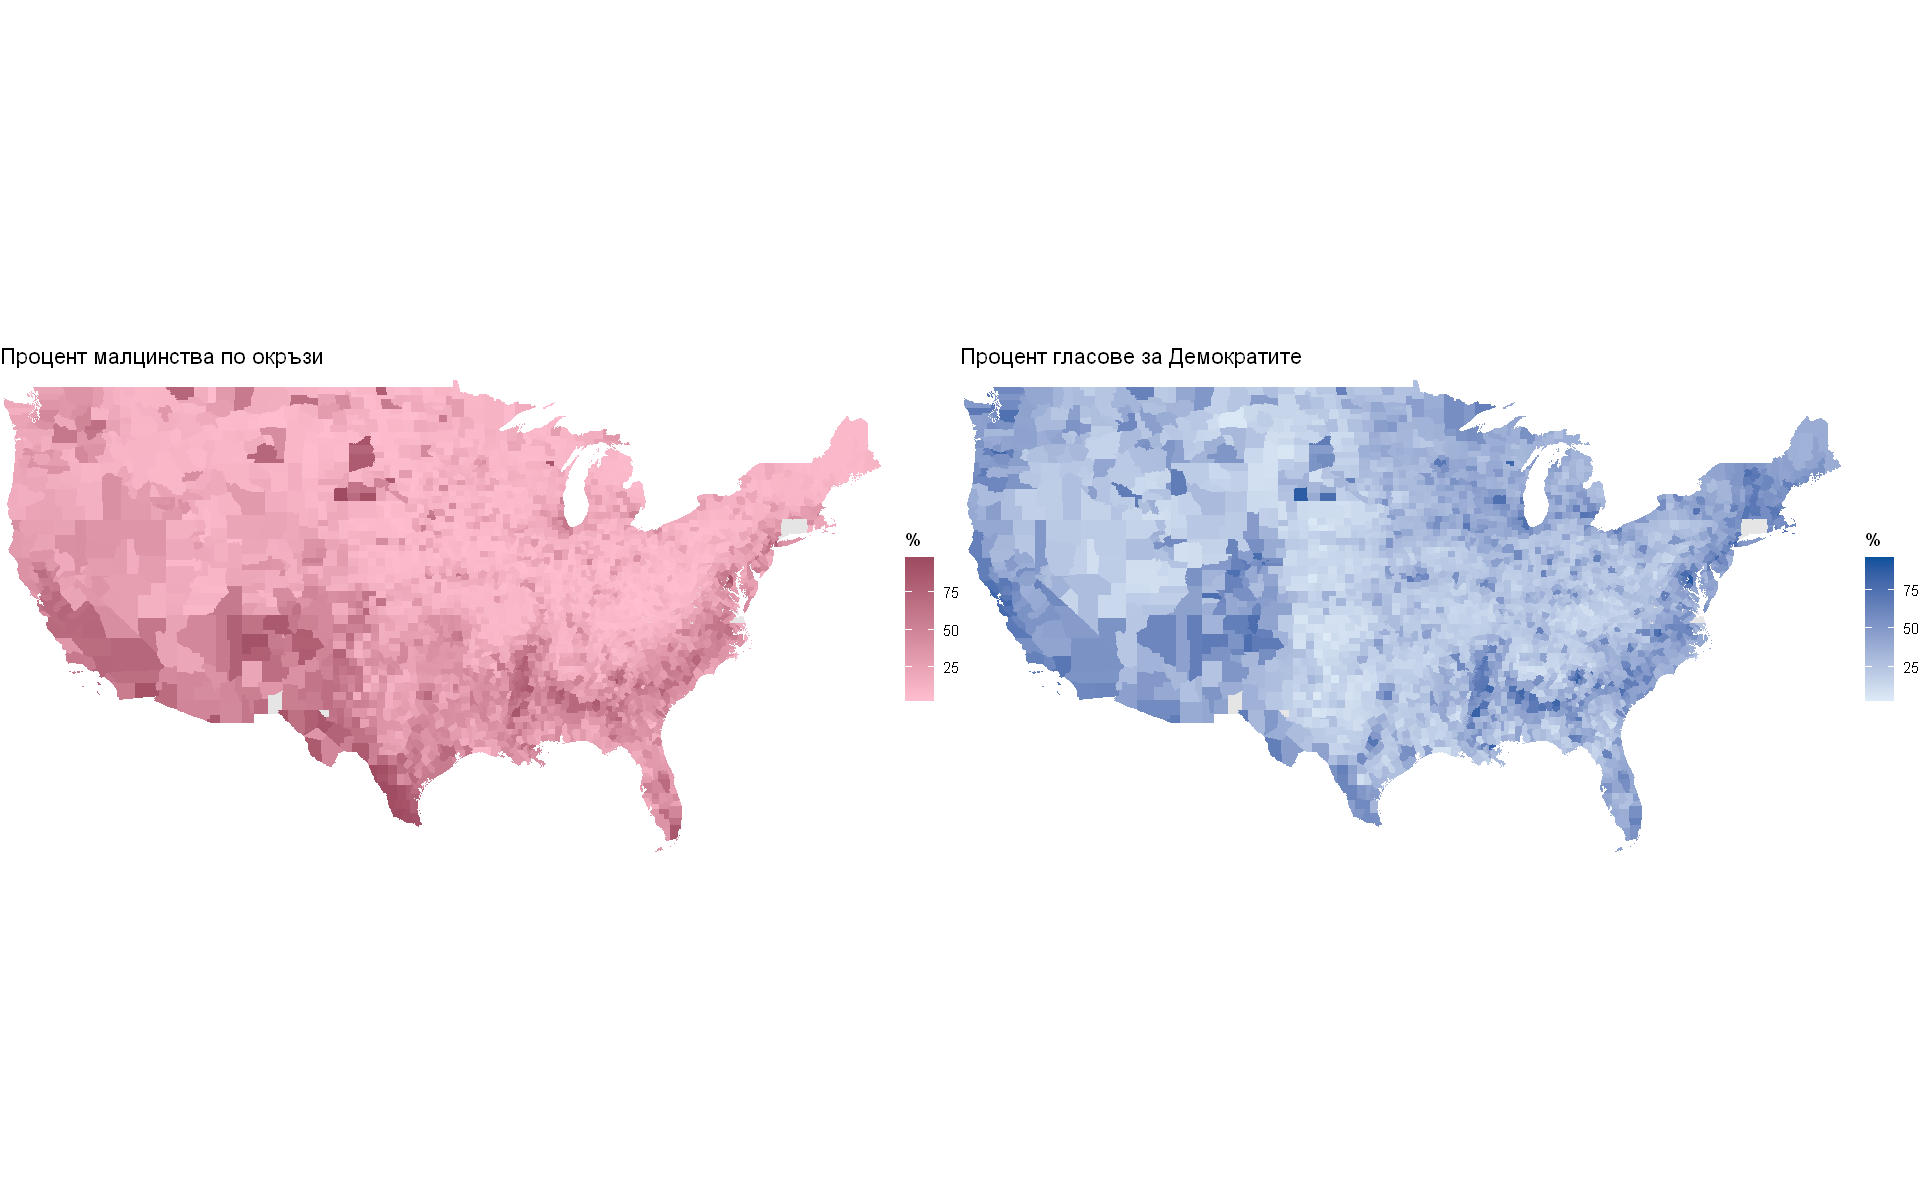

In [17]:
options(repr.plot.width = 16, repr.plot.height = 10)
min_per <- ggplot(map_data) +
  geom_sf(aes(fill = 100 - NH.White.percentage), color = NA) +
  scale_fill_gradient(
    low = "#ffbfd0", 
    high = "#9e4a60",  
    na.value = "gray90",
    name = "%"
  ) +
  coord_sf(xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE) +
  theme_void() +
  labs(title = "Процент малцинства по окръзи")
grid.arrange(min_per, dems_per, ncol=2, widths = c(1, 1))

В заключение, от картите се вижда, че колкото по-нисък е процентът бели в даден окръг, толкова по-висок е резултатът на Демократите. 

#### Икономически анализ
Разглеждаме за връзки следните двойки:
- процент гласували за Демократите срещу процент хора с висше образование (бакалавър и по-нагоре)
- процент гласували за Демократите срещу медианата на доходите
- процент гласували за Демократите срещу процент работещи в сферите на управлението, бизнеса, науката и изкуството

`geom_smooth()` using formula = 'y ~ x'


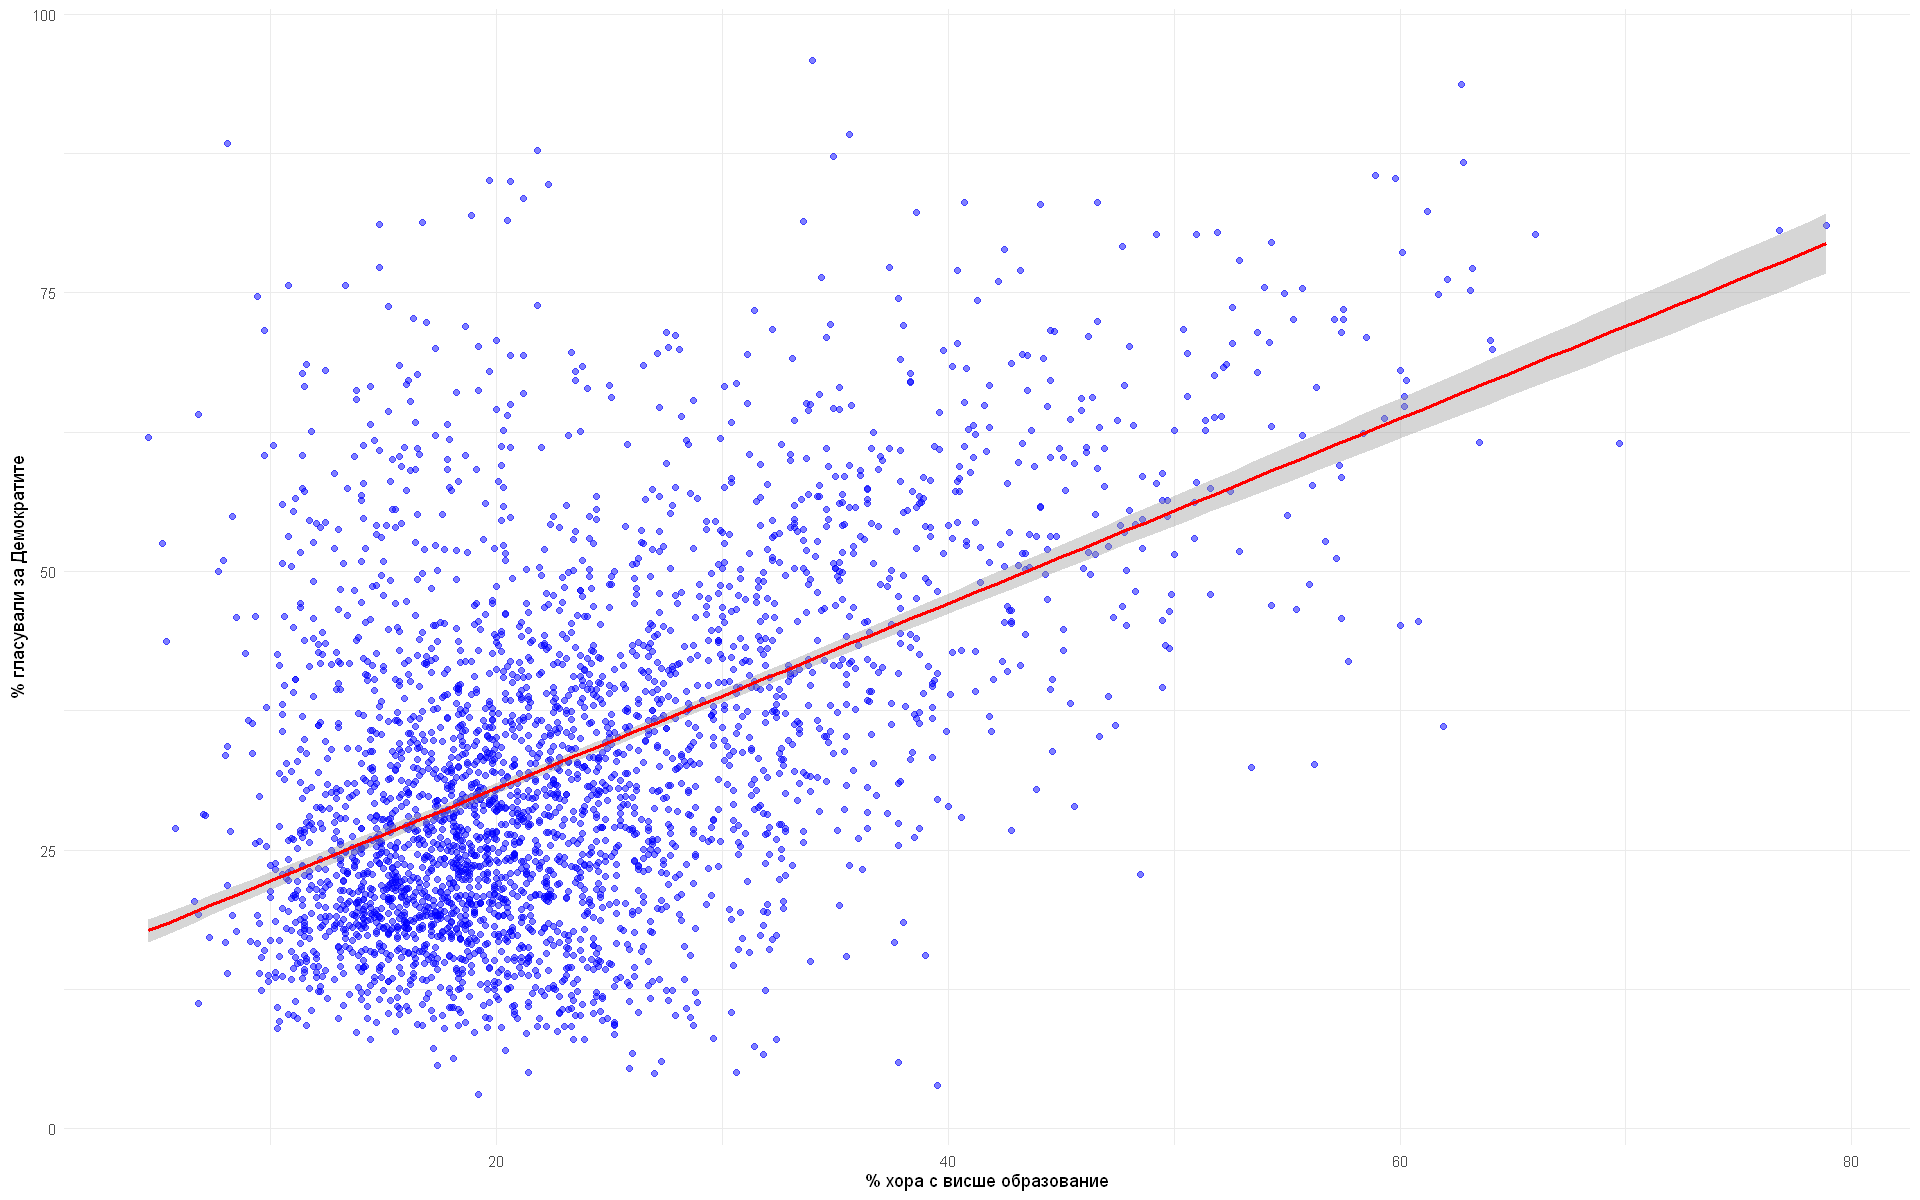

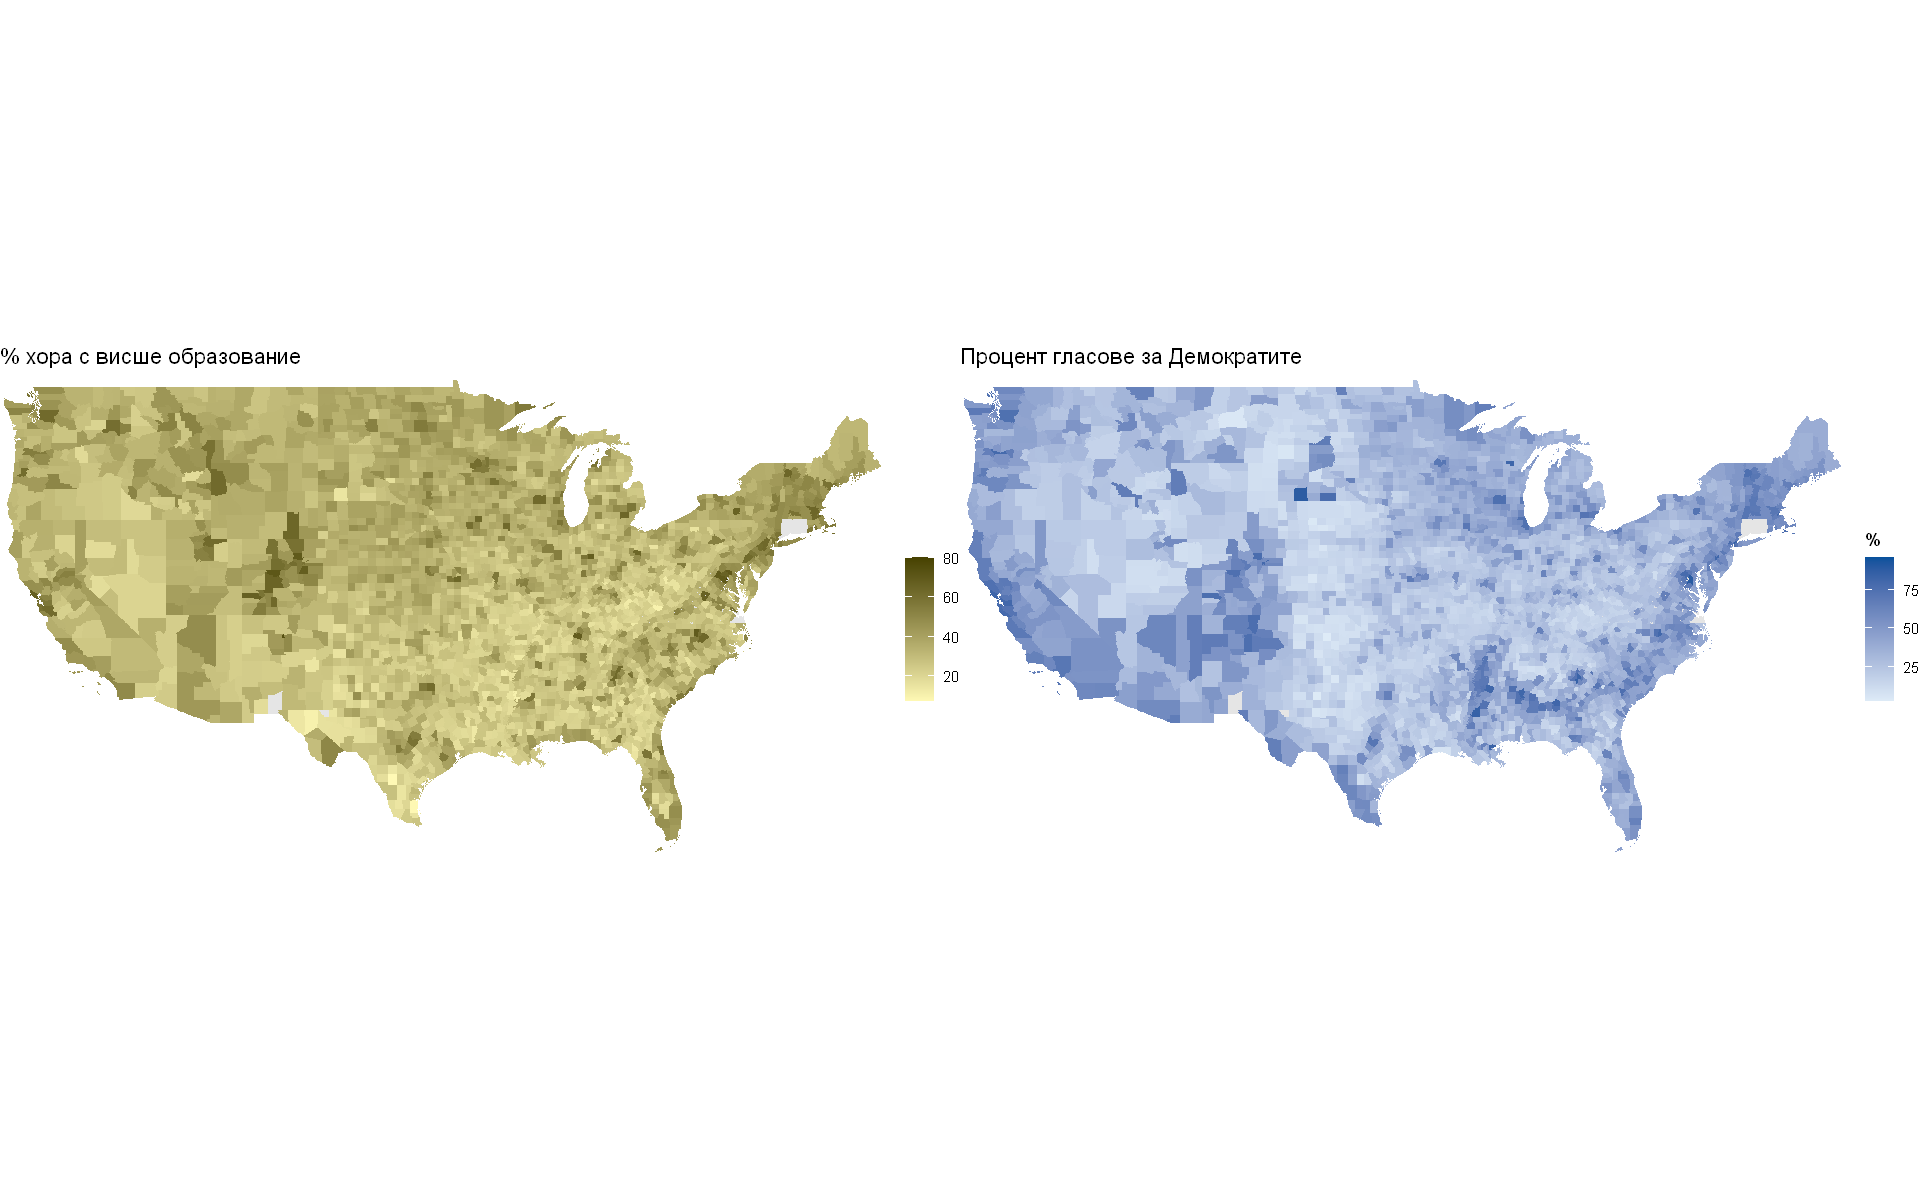

In [18]:
ggplot(data, aes(x = Bachelors.Degree + Graduate.or.professional.degree, y = X2020.Democrat.vote..)) + 
    geom_point(alpha = 0.5, color = "blue") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(x = "% хора с висше образование", y = "% гласували за Демократите") + 
    theme_minimal()

options(repr.plot.width = 16, repr.plot.height = 10)
higher_ed_per <- ggplot(map_data) +
  geom_sf(aes(fill = Associates.Degree + Bachelors.Degree + Graduate.or.professional.degree), color = NA) +
  scale_fill_gradient(
    low = "#fff9b5",   
    high = "#474201",  
    na.value = "gray90",
    name = "") +
  coord_sf(xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE) +
  theme_void() +
  labs(title = "% хора с висше образование")
grid.arrange(higher_ed_per, dems_per, ncol=2, widths = c(1, 1))

Графиката тук показва следното: увеличението на процента гласове за Демократите не предопределя висок процент хора с висше образование, но обратното е в сила - колкото повече се увеличава процента на хората с висше образование, забелязваме увеличение в гласовете за Демократите. 

`geom_smooth()` using formula = 'y ~ x'


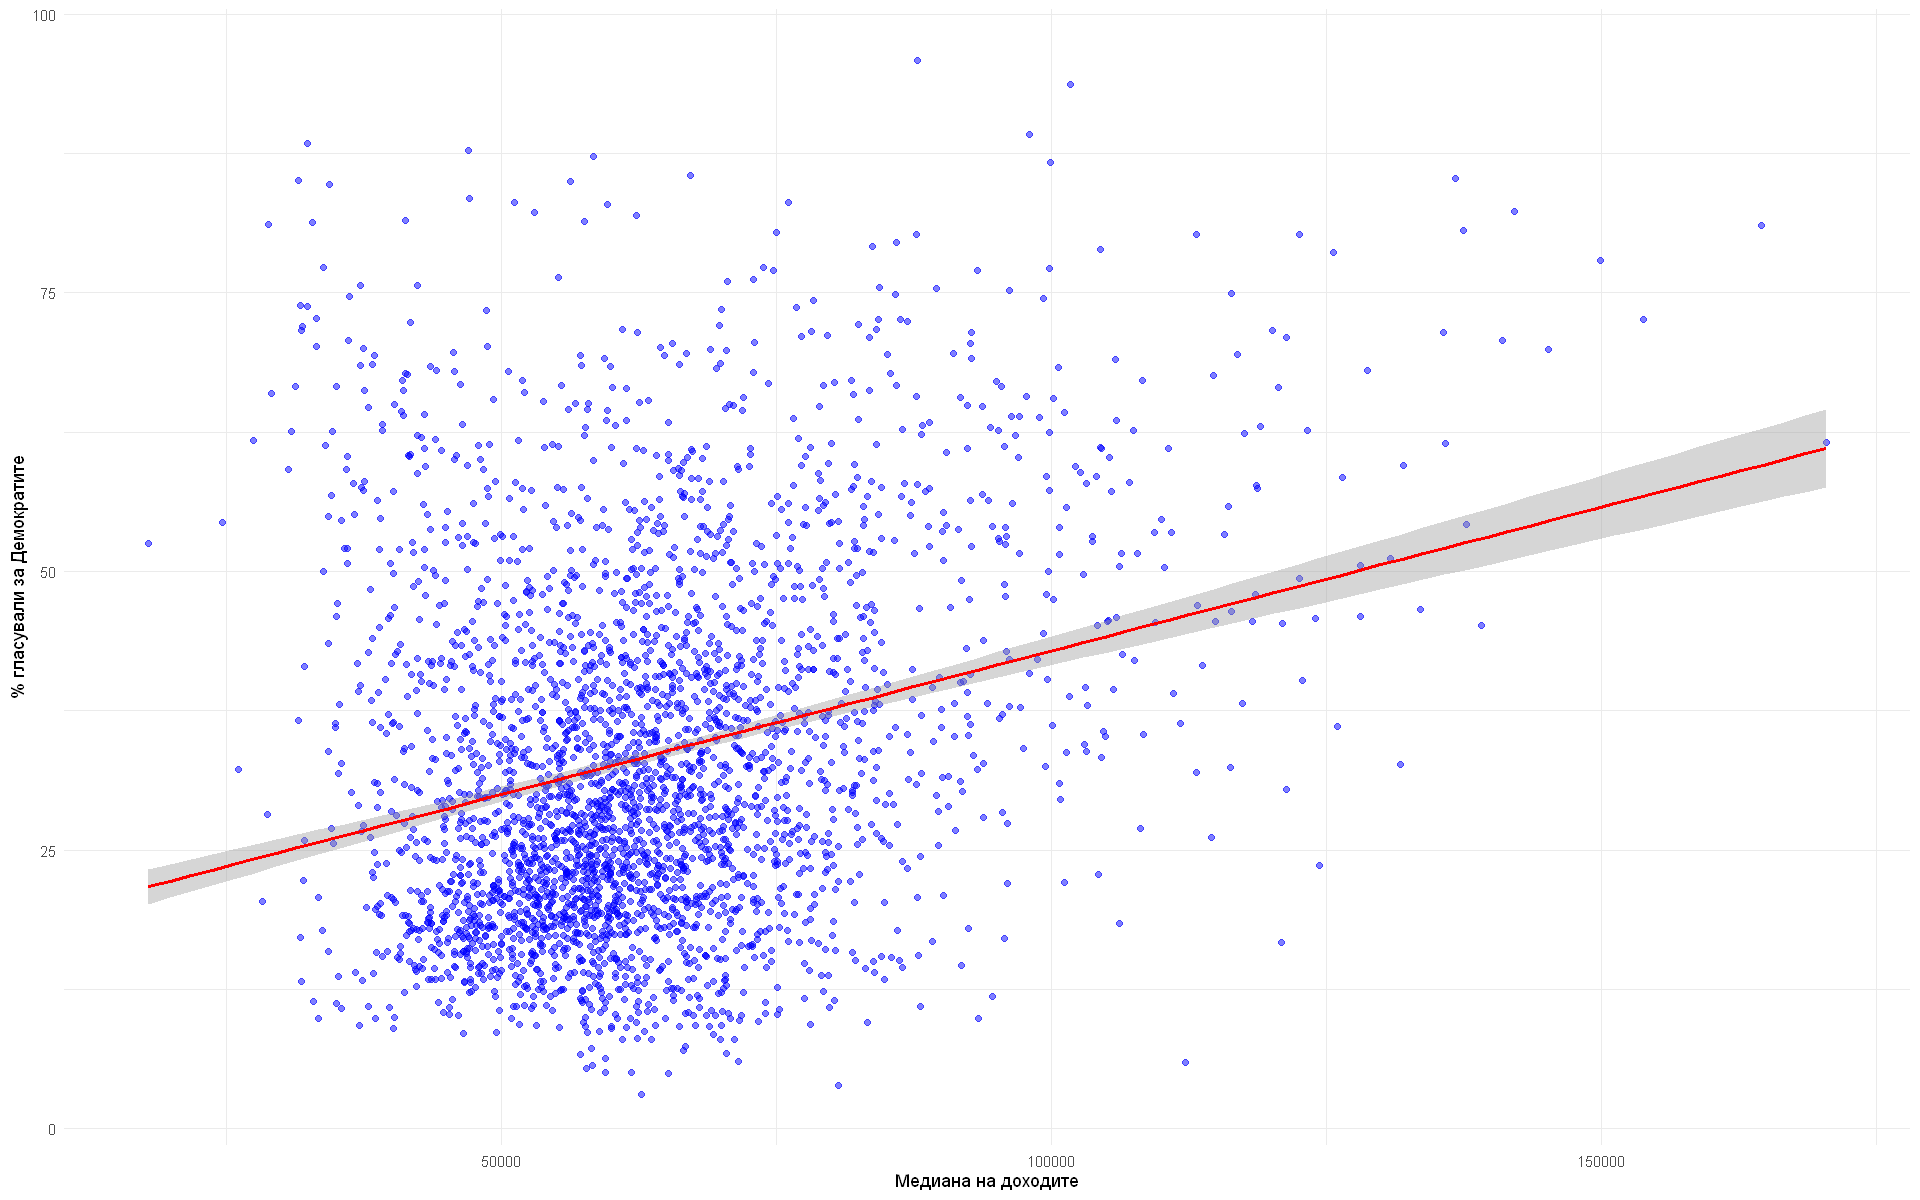

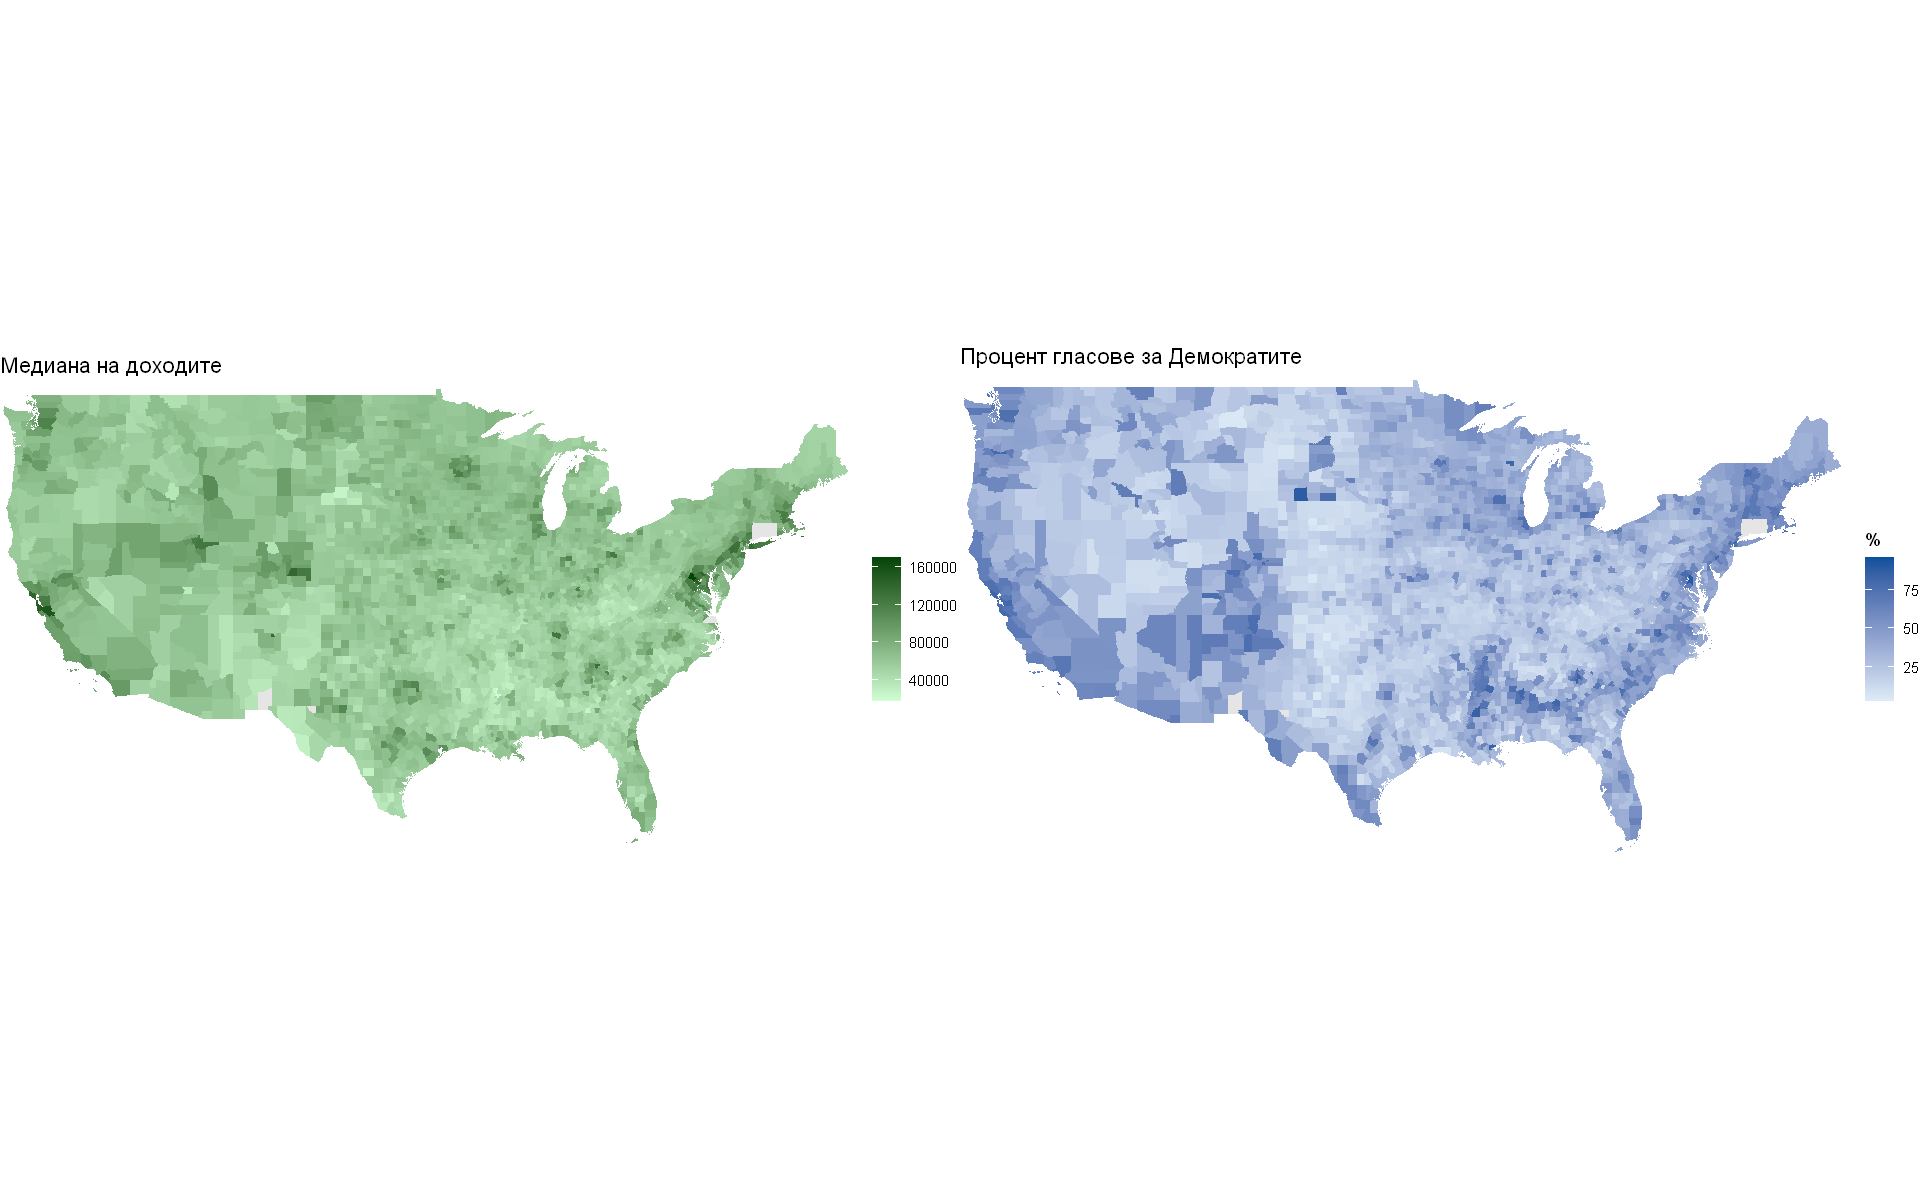

In [19]:
ggplot(data, aes(x = Median.income..dollars., y = X2020.Democrat.vote..)) + 
    geom_point(alpha = 0.5, color = "blue") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(x = "Медиана на доходите", y = "% гласували за Демократите") + 
    theme_minimal()

options(repr.plot.width = 16, repr.plot.height = 10)
median_income <- ggplot(map_data) +
  geom_sf(aes(fill = Median.income..dollars.), color = NA) +
  scale_fill_gradient(
    low = "#d1ffd5",   
    high = "#014507",  
    na.value = "gray90",
    name = "") +
  coord_sf(xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE) +
  theme_void() +
  labs(title = "Медиана на доходите")
grid.arrange(median_income, dems_per, ncol=2, widths = c(1, 1))

Тук забелязваме следната тенденция - с увеличаването на медианата на доходите в даден окръг, се увеличава и процентът гласували за Демократите. Можем да забележим, че именно това доказва по-високите изборни резултати на партията в големите градове и техните покрайнини.

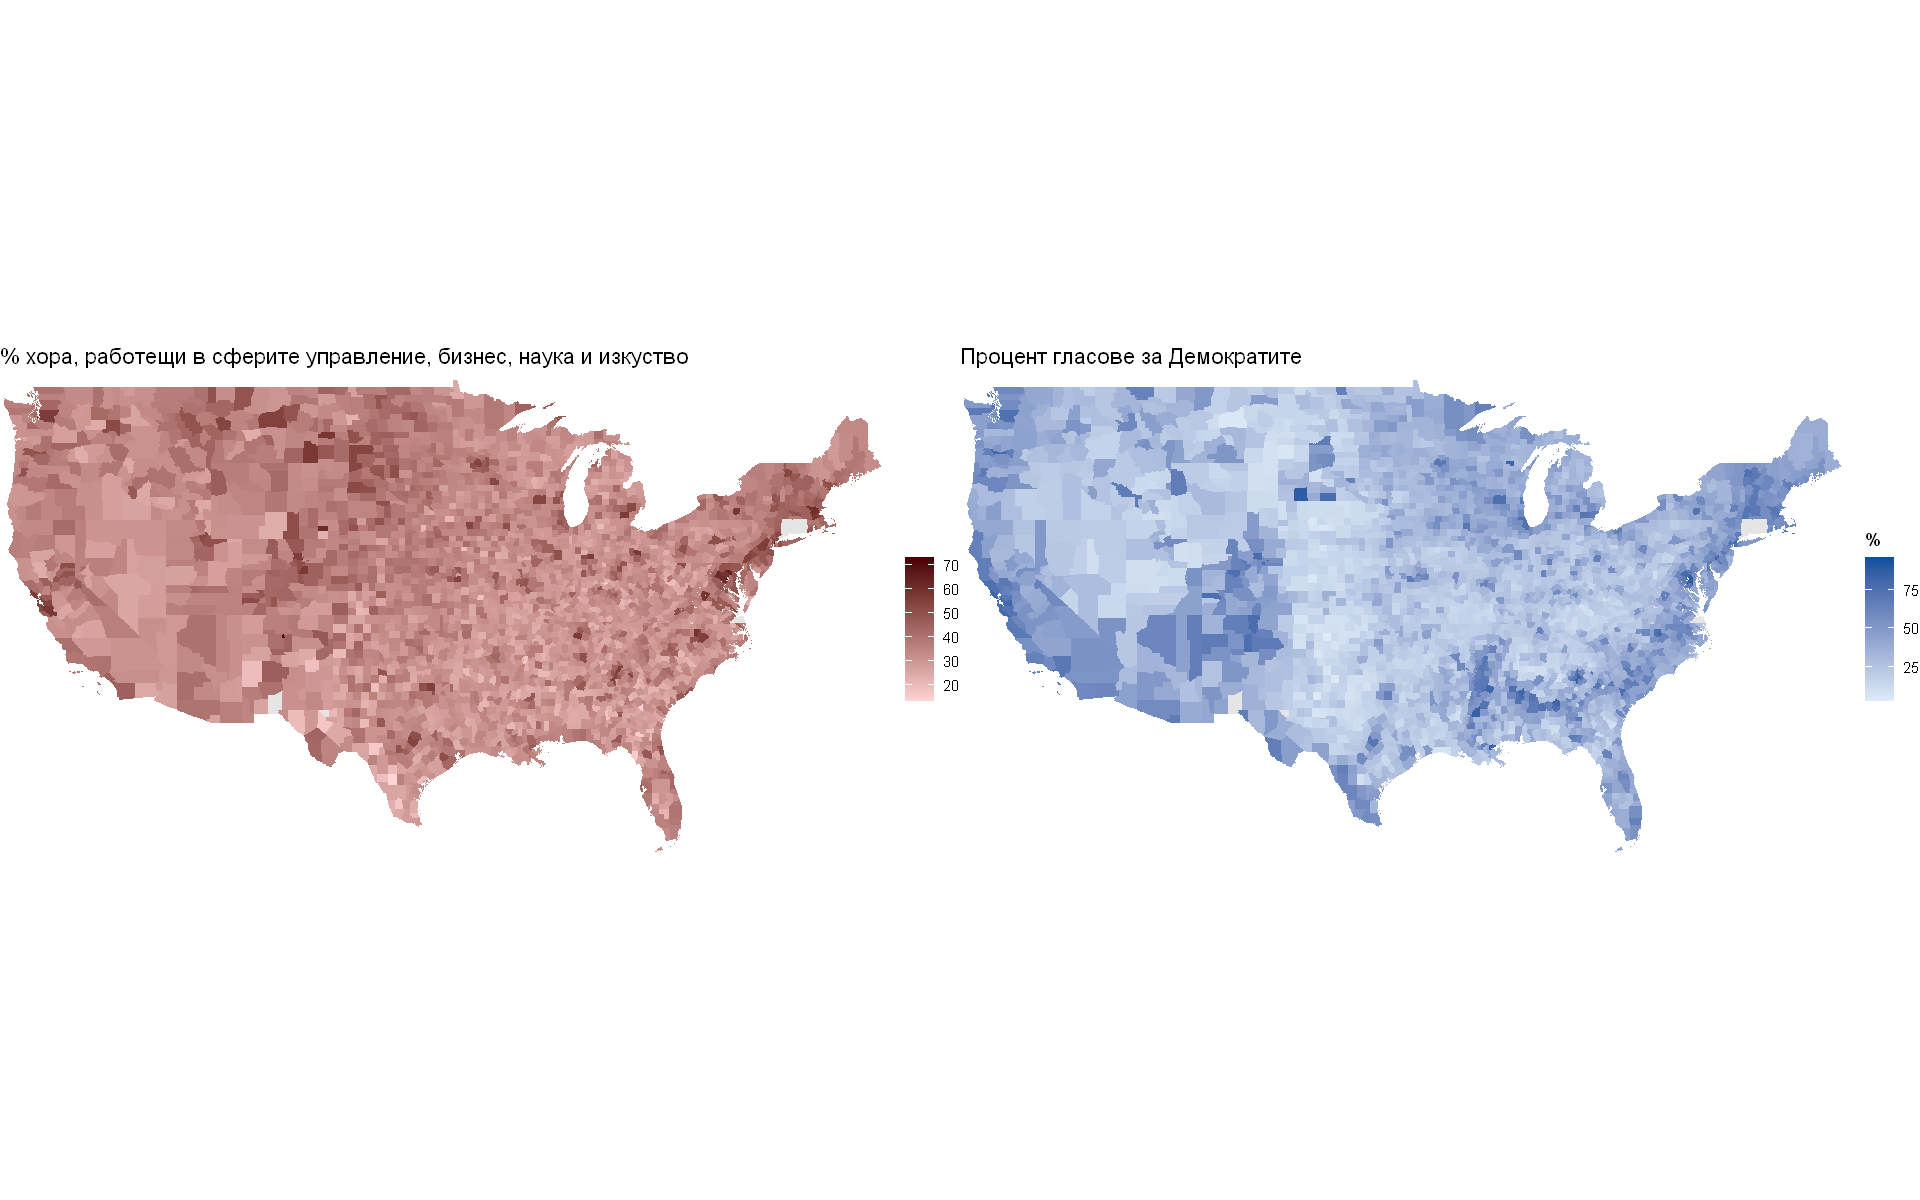

In [20]:
options(repr.plot.width = 16, repr.plot.height = 10)
mbsa_per <- ggplot(map_data) +
  geom_sf(aes(fill = Percentage.engaged.in.Management..business..science..and.arts.occupations), color = NA) +
  scale_fill_gradient(
    low = "#ffd4d4",   
    high = "#4a0000",  
    na.value = "gray90",
    name = "") +
  coord_sf(xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE) +
  theme_void() +
  labs(title = "% хора, работещи в сферите управление, бизнес, наука и изкуство")
grid.arrange(mbsa_per, dems_per, ncol=2, widths = c(1, 1))

Виждаме и връзка между процента хора, работещи в сферите управление, бизнес, наука и изкуство, и резултатите на Демократите. Това се обяснява, поради факта, че концентрация на хора, работещи в тези сфери, има предимно в големите градове и техните покрайнини, които, както видяхме по-горе, гласуват предимно за Демократите.


### Корелационен анализ
Ще сравним няколко двойки променливи за корелация помежду им:

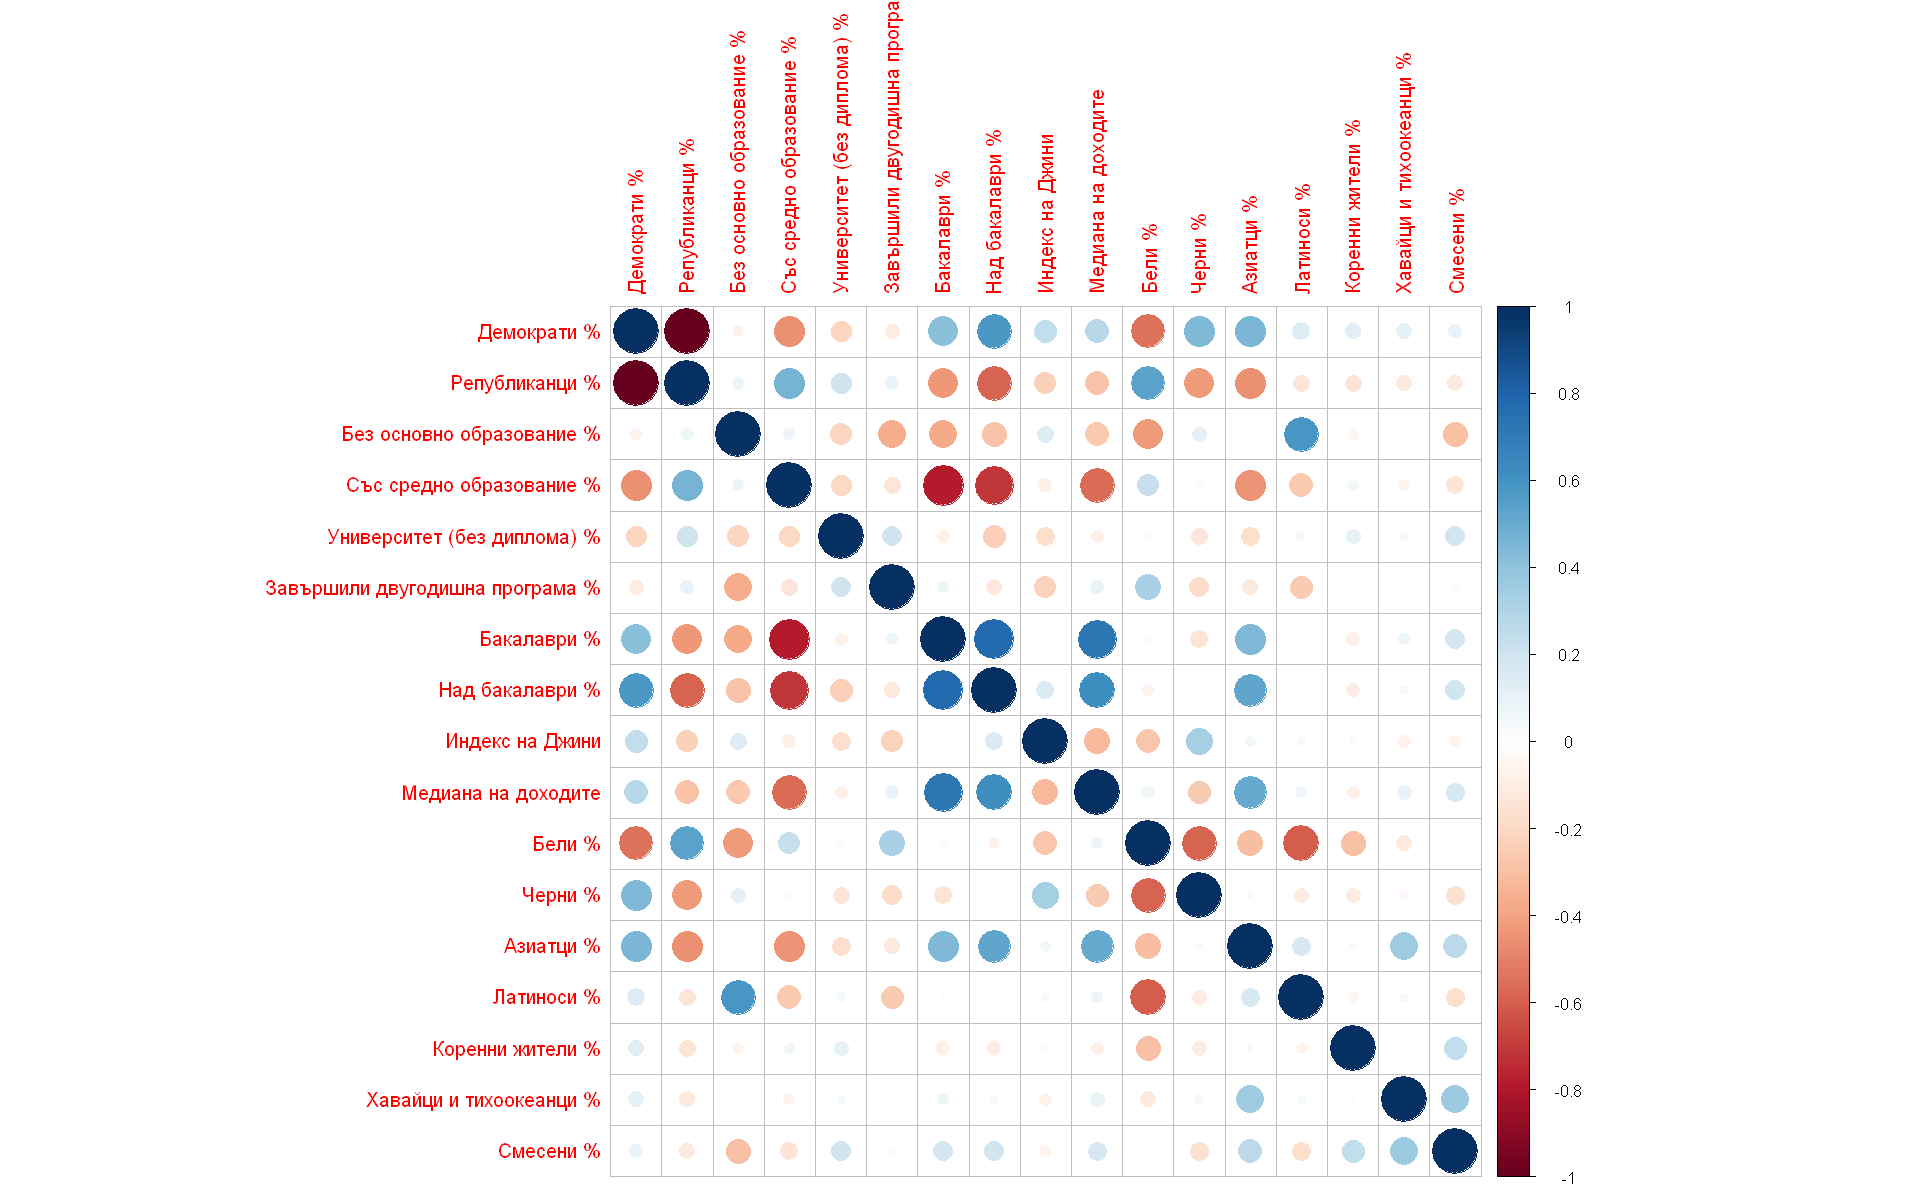

In [21]:
cor_analysis_cols <- c("X2020.Democrat.vote..", "X2020.Republican.vote..", "Population.with.less.than.9th.grade.education",
                      "High.School.graduate.and.equivalent", "Some.College.No.Degree", "Associates.Degree", "Bachelors.Degree",
                      "Graduate.or.professional.degree", "Gini.Index", "Median.income..dollars.", "NH.White.percentage", "NH.Black.percentage", "NH.Asian.percentage", "Hispanic.or.Latino.percentage",
                      "NH.American.Indian.and.Alaska.Native.percentage", "NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage", "NH.Two.or.More.Races.percentage")
M <- cor(data[, cor_analysis_cols])
colnames(M) <- c("Демократи %", "Републиканци %", "Без основно образование %", "Със средно образование %", 
                 "Университет (без диплома) %", "Завършили двугодишна програма %", "Бакалаври %", "Над бакалаври %", 
                 "Индекс на Джини", "Медиана на доходите", "Бели %", "Черни %", "Азиатци %", "Латиноси %", 
                 "Коренни жители %", "Хавайци и тихоокеанци %", "Смесени %")
rownames(M) <- colnames(M)
corrplot(M)

Този plot показва връзки, каквито видяхме и чрез картите по-горе. Например отрицателният коефициент на корелация между процента на Демократите и процента бели хора в окръга показва, че с увеличаването на процента бели хора в окръга, процента от избори на Демократите спада.

### Тестове
За да разберем как точно да сравняваме две извадки, трябва да направим тестове за нормалност. </br>

*Бележка:* За тестовете с проверка на хипотези определяме и ще използваме ниво на съгласие **alpha = 0.05**

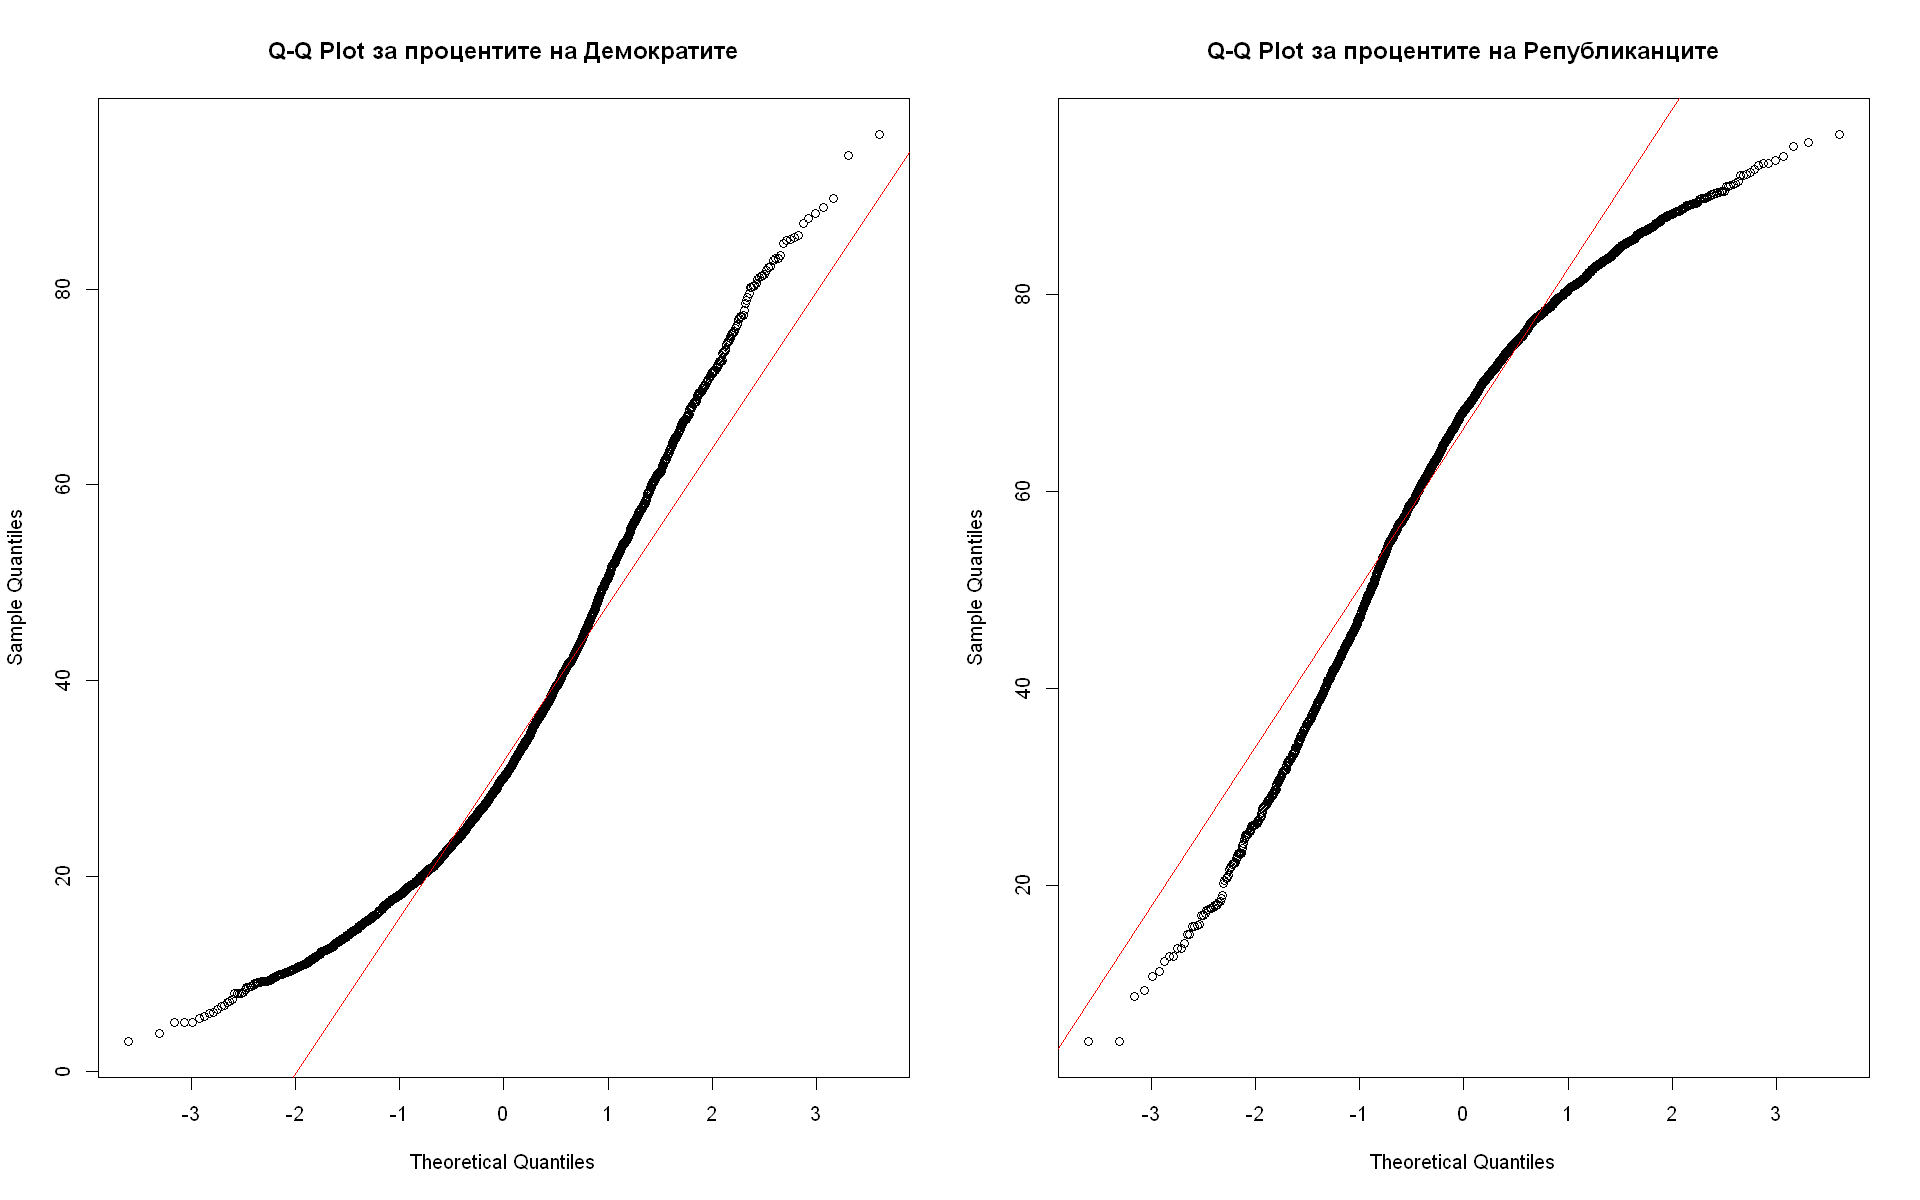

In [22]:
par(mfrow = c(1, 2))
qqnorm(data$X2020.Democrat.vote.., main = "Q-Q Plot за процентите на Демократите")
qqline(data$X2020.Democrat.vote.., col = "red")
qqnorm(data$X2020.Republican.vote.., main = "Q-Q Plot за процентите на Републиканците")
qqline(data$X2020.Republican.vote.., col = "red")
par(mfrow = c(1, 1))

Както се вижда процентовите резултати на Демократите и Републиканците не са нормално разпределени, поради наличието на много outlier-и. Ще покажем това и с Shapiro-Wilk test:

In [23]:
shapiro.test(data$X2020.Democrat.vote..)
shapiro.test(data$X2020.Republican.vote..)


	Shapiro-Wilk normality test

data:  data$X2020.Democrat.vote..
W = 0.94713, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  data$X2020.Republican.vote..
W = 0.94946, p-value < 2.2e-16


Нулевата хипотеза на Shapiro-Wilk теста е, че данните са нормално разпределени. Тук p-value < alpha = 0.05, следователно отхвърляме нулевата хипотеза, тоест нито процентите на Демократите, нито процентите на Републиканците са нормално разпределени. </br>
Нека тестваме и някои от останалите променливи, които ще участват в модела:

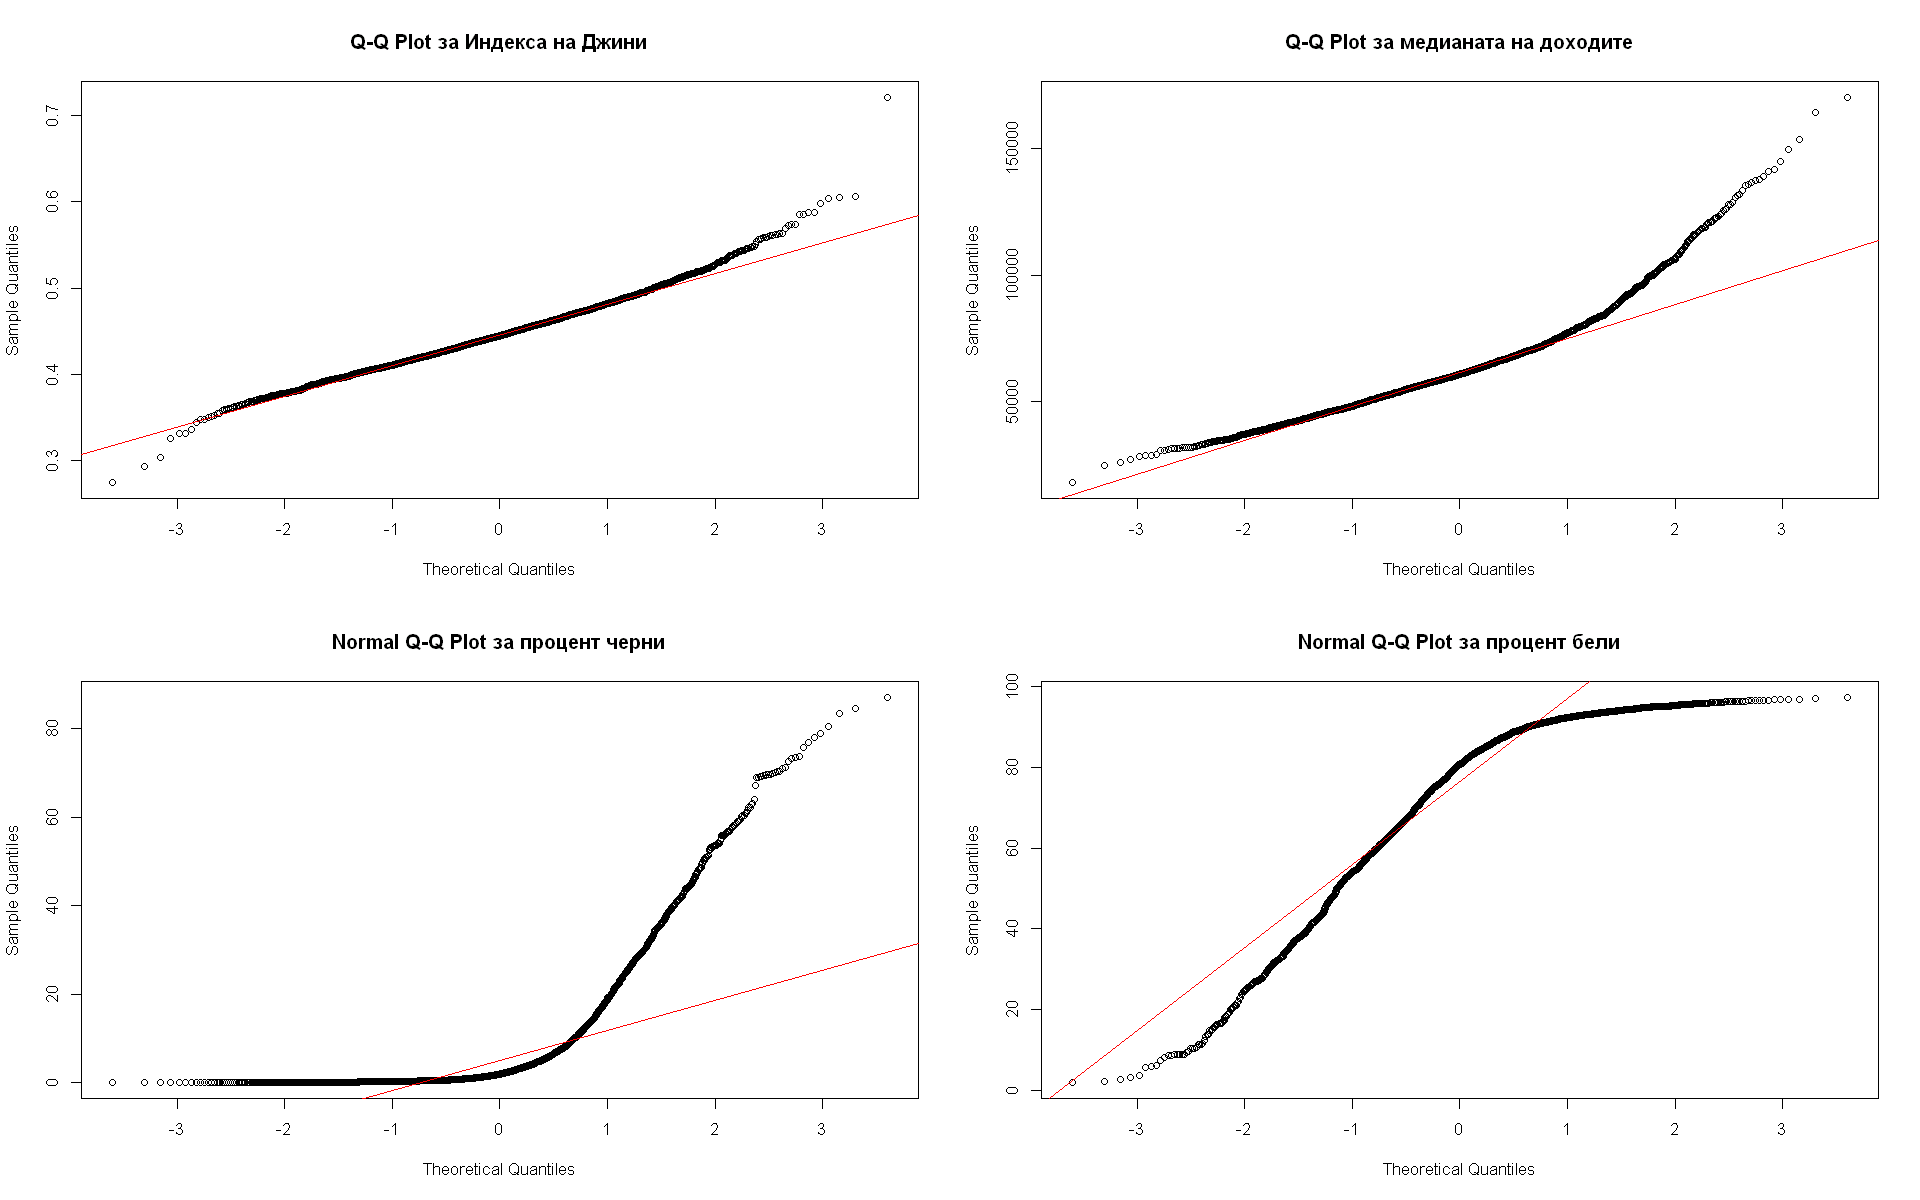

In [24]:
par(mfrow = c(2, 2))
qqnorm(data$Gini.Index, main = "Q-Q Plot за Индекса на Джини")
qqline(data$Gini.Index, col = "red")
qqnorm(data$Median.income..dollars., main = "Q-Q Plot за медианата на доходите")
qqline(data$Median.income..dollars., col = "red")
qqnorm(data$NH.Black.percentage, main = "Normal Q-Q Plot за процент черни")
qqline(data$NH.Black.percentage, col = "red")
qqnorm(data$NH.White.percentage, main = "Normal Q-Q Plot за процент бели")
qqline(data$NH.White.percentage, col = "red")
par(mfrow = c(1, 1))

Очевидно и четирите променливи не са нормално разпределени. Нека все пак направим и Shapiro-Wilk тестовете:

In [25]:
shapiro.test(data$Gini.Index)
shapiro.test(data$Median.income..dollars.)
shapiro.test(data$NH.Black.percentage)
shapiro.test(data$NH.White.percentage)


	Shapiro-Wilk normality test

data:  data$Gini.Index
W = 0.9855, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  data$Median.income..dollars.
W = 0.92647, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  data$NH.Black.percentage
W = 0.64778, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  data$NH.White.percentage
W = 0.88031, p-value < 2.2e-16


За индекса на Джини и медианата на доходите получаваме W стойности близо до 1, което показва, че данните наподобяват нормално разпределение. Обаче p-value < alpha = 0.05, тоест отхвърляме хипотезите, че разпределенията са нормални. Тези на пръв поглед противоречиви резултати се дължат на това, че в извадките има много outlier-и (както се вижда на графиките горе), а Shapiro-Wilk теста е чувствителен към тях. </br> </br>

В заключение, данните ни не са нормално разпределени, тоест няма как да използваме параметрични тестове за извадки. Затова използваме непараметрични тестове (като например Wilcoxon test)

In [26]:
wilcox.test(data$X2020.Democrat.vote.., data$X2020.Republican.vote..)


	Wilcoxon rank sum test with continuity correction

data:  data$X2020.Democrat.vote.. and data$X2020.Republican.vote..
W = 977584, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


Нулевата хипотеза в Wilcoxon теста е, че медианите на двете променливи не се различават много. Тук p-value < alpha = 0.05, тоест отхвърляме тази хипотеза. Наистина, има доста голяма разлика между медианите на процентите на Демократите и Републиканците, което се дължи на факта, че републиканците печелят в много окръзи с доста малък брой хора (обикновено outlier-ите спрямо населението в лявата част), и тези победи са с доста голяма разлика, в сравнение с Демократите. Медианите им са дадени долу:

In [27]:
median(data$X2020.Democrat.vote..)
median(data$X2020.Republican.vote..)

[1] 30.065

[1] 68.155

## Линейни модели
Дойде и времето да направим моделите за предсказване на победител на изборите в някакъв хипотетичен окръг. Ще направим два модела - многомерна линейна регресия и многомерна логистична регресия, ще сравним двата модела и ще изберем по-добрия от двата.
### Многомерна линейна регресия


In [28]:
lm_model <- lm(X2020.Democrat.vote.. ~ Population.with.less.than.9th.grade.education +
High.School.graduate.and.equivalent + Some.College.No.Degree + Associates.Degree + Bachelors.Degree +  Total.Population +
Graduate.or.professional.degree + Gini.Index + Median.income..dollars. + NH.White.percentage + NH.Black.percentage + NH.Asian.percentage + Hispanic.or.Latino.percentage +
NH.American.Indian.and.Alaska.Native.percentage + NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage + NH.Two.or.More.Races.percentage +
               Percentage.engaged.in.Management..business..science..and.arts.occupations + Percentage.engaged.in.Service.Occupations +
               Percentage.engaged.in.Sales.and.Office + Percentage.engaged.in.Resources.and.Construction + Percentage.engaged.in.Transportation, data = data)
summary(lm_model)


Call:
lm(formula = X2020.Democrat.vote.. ~ Population.with.less.than.9th.grade.education + 
    High.School.graduate.and.equivalent + Some.College.No.Degree + 
    Associates.Degree + Bachelors.Degree + Total.Population + 
    Graduate.or.professional.degree + Gini.Index + Median.income..dollars. + 
    NH.White.percentage + NH.Black.percentage + NH.Asian.percentage + 
    Hispanic.or.Latino.percentage + NH.American.Indian.and.Alaska.Native.percentage + 
    NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage + 
    NH.Two.or.More.Races.percentage + Percentage.engaged.in.Management..business..science..and.arts.occupations + 
    Percentage.engaged.in.Service.Occupations + Percentage.engaged.in.Sales.and.Office + 
    Percentage.engaged.in.Resources.and.Construction + Percentage.engaged.in.Transportation, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-31.105  -5.702  -0.468   5.188  37.194 

Coefficients:
                                                   

Тук виждаме, че някои от променливите не са значими в линейния модел. Затова ще ги махнем:

In [29]:
lm_model <- lm(X2020.Democrat.vote.. ~ Population.with.less.than.9th.grade.education +
High.School.graduate.and.equivalent + Associates.Degree + Bachelors.Degree + Total.Population +
Graduate.or.professional.degree + NH.White.percentage + Median.income..dollars. + NH.Black.percentage + NH.Asian.percentage + Hispanic.or.Latino.percentage +
NH.American.Indian.and.Alaska.Native.percentage + NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage + NH.Two.or.More.Races.percentage, data = data)
summary(lm_model)


Call:
lm(formula = X2020.Democrat.vote.. ~ Population.with.less.than.9th.grade.education + 
    High.School.graduate.and.equivalent + Associates.Degree + 
    Bachelors.Degree + Total.Population + Graduate.or.professional.degree + 
    NH.White.percentage + Median.income..dollars. + NH.Black.percentage + 
    NH.Asian.percentage + Hispanic.or.Latino.percentage + NH.American.Indian.and.Alaska.Native.percentage + 
    NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage + 
    NH.Two.or.More.Races.percentage, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.571  -6.168  -0.461   5.599  47.469 

Coefficients:
                                                           Estimate Std. Error
(Intercept)                                               8.460e+02  8.802e+01
Population.with.less.than.9th.grade.education             1.767e-01  7.972e-02
High.School.graduate.and.equivalent                       5.879e-01  4.878e-02
Associates.Degree                           

Моделът има Adjusted R-squared над 0.5, тоест моделът не е слаб.

### Многомерна логистична регресия
Тъй като многомерната логистична регресия работи с бинарни променливи, ще въведем нова променлива **result**, която ще бъде равна на 1, ако Демократите са спечелили дадения окръг (имат повече гласове), и 0 иначе (реално може да се каже и "0, ако Републиканците печелят", понеже системата в САЩ е де факто двупартийна).

In [30]:
data$Result <- ifelse(data$X2020.Democrat.vote.. > data$X2020.Republican.vote.., 1, 0)
data$Result <- factor(data$Result, labels = c("Republican", "Democrat"))

log_model <- glm(Result ~ Population.with.less.than.9th.grade.education +
High.School.graduate.and.equivalent + Some.College.No.Degree + Associates.Degree + Bachelors.Degree + Total.Population +
Graduate.or.professional.degree + Gini.Index + Median.income..dollars. + NH.White.percentage + NH.Black.percentage + NH.Asian.percentage + Hispanic.or.Latino.percentage +
NH.American.Indian.and.Alaska.Native.percentage + NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage + NH.Two.or.More.Races.percentage +
               Percentage.engaged.in.Management..business..science..and.arts.occupations + Percentage.engaged.in.Service.Occupations +
               Percentage.engaged.in.Sales.and.Office + Percentage.engaged.in.Resources.and.Construction + Percentage.engaged.in.Transportation, data = data, family = "binomial")
summary(log_model)


Call:
glm(formula = Result ~ Population.with.less.than.9th.grade.education + 
    High.School.graduate.and.equivalent + Some.College.No.Degree + 
    Associates.Degree + Bachelors.Degree + Total.Population + 
    Graduate.or.professional.degree + Gini.Index + Median.income..dollars. + 
    NH.White.percentage + NH.Black.percentage + NH.Asian.percentage + 
    Hispanic.or.Latino.percentage + NH.American.Indian.and.Alaska.Native.percentage + 
    NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage + 
    NH.Two.or.More.Races.percentage + Percentage.engaged.in.Management..business..science..and.arts.occupations + 
    Percentage.engaged.in.Service.Occupations + Percentage.engaged.in.Sales.and.Office + 
    Percentage.engaged.in.Resources.and.Construction + Percentage.engaged.in.Transportation, 
    family = "binomial", data = data)

Coefficients:
                                                                            Estimate
(Intercept)                                          

И тук виждаме, че някои от променливите не са значими в модела. Затова ще ги махнем:

In [31]:
log_model <- glm(Result ~ High.School.graduate.and.equivalent + Associates.Degree + Bachelors.Degree + Total.Population +
Graduate.or.professional.degree + Median.income..dollars. + NH.White.percentage + NH.Black.percentage + NH.Asian.percentage + Hispanic.or.Latino.percentage +
NH.American.Indian.and.Alaska.Native.percentage + NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage + NH.Two.or.More.Races.percentage, data = data, family = "binomial")
summary(log_model)


Call:
glm(formula = Result ~ High.School.graduate.and.equivalent + 
    Associates.Degree + Bachelors.Degree + Total.Population + 
    Graduate.or.professional.degree + Median.income..dollars. + 
    NH.White.percentage + NH.Black.percentage + NH.Asian.percentage + 
    Hispanic.or.Latino.percentage + NH.American.Indian.and.Alaska.Native.percentage + 
    NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage + 
    NH.Two.or.More.Races.percentage, family = "binomial", data = data)

Coefficients:
                                                           Estimate Std. Error
(Intercept)                                               1.146e+02  4.487e+01
High.School.graduate.and.equivalent                       1.088e-01  2.355e-02
Associates.Degree                                         1.488e-01  3.839e-02
Bachelors.Degree                                          1.942e-01  2.978e-02
Total.Population                                          1.238e-06  4.118e-07
Graduate.or.professio

### Анализ на линейния модел

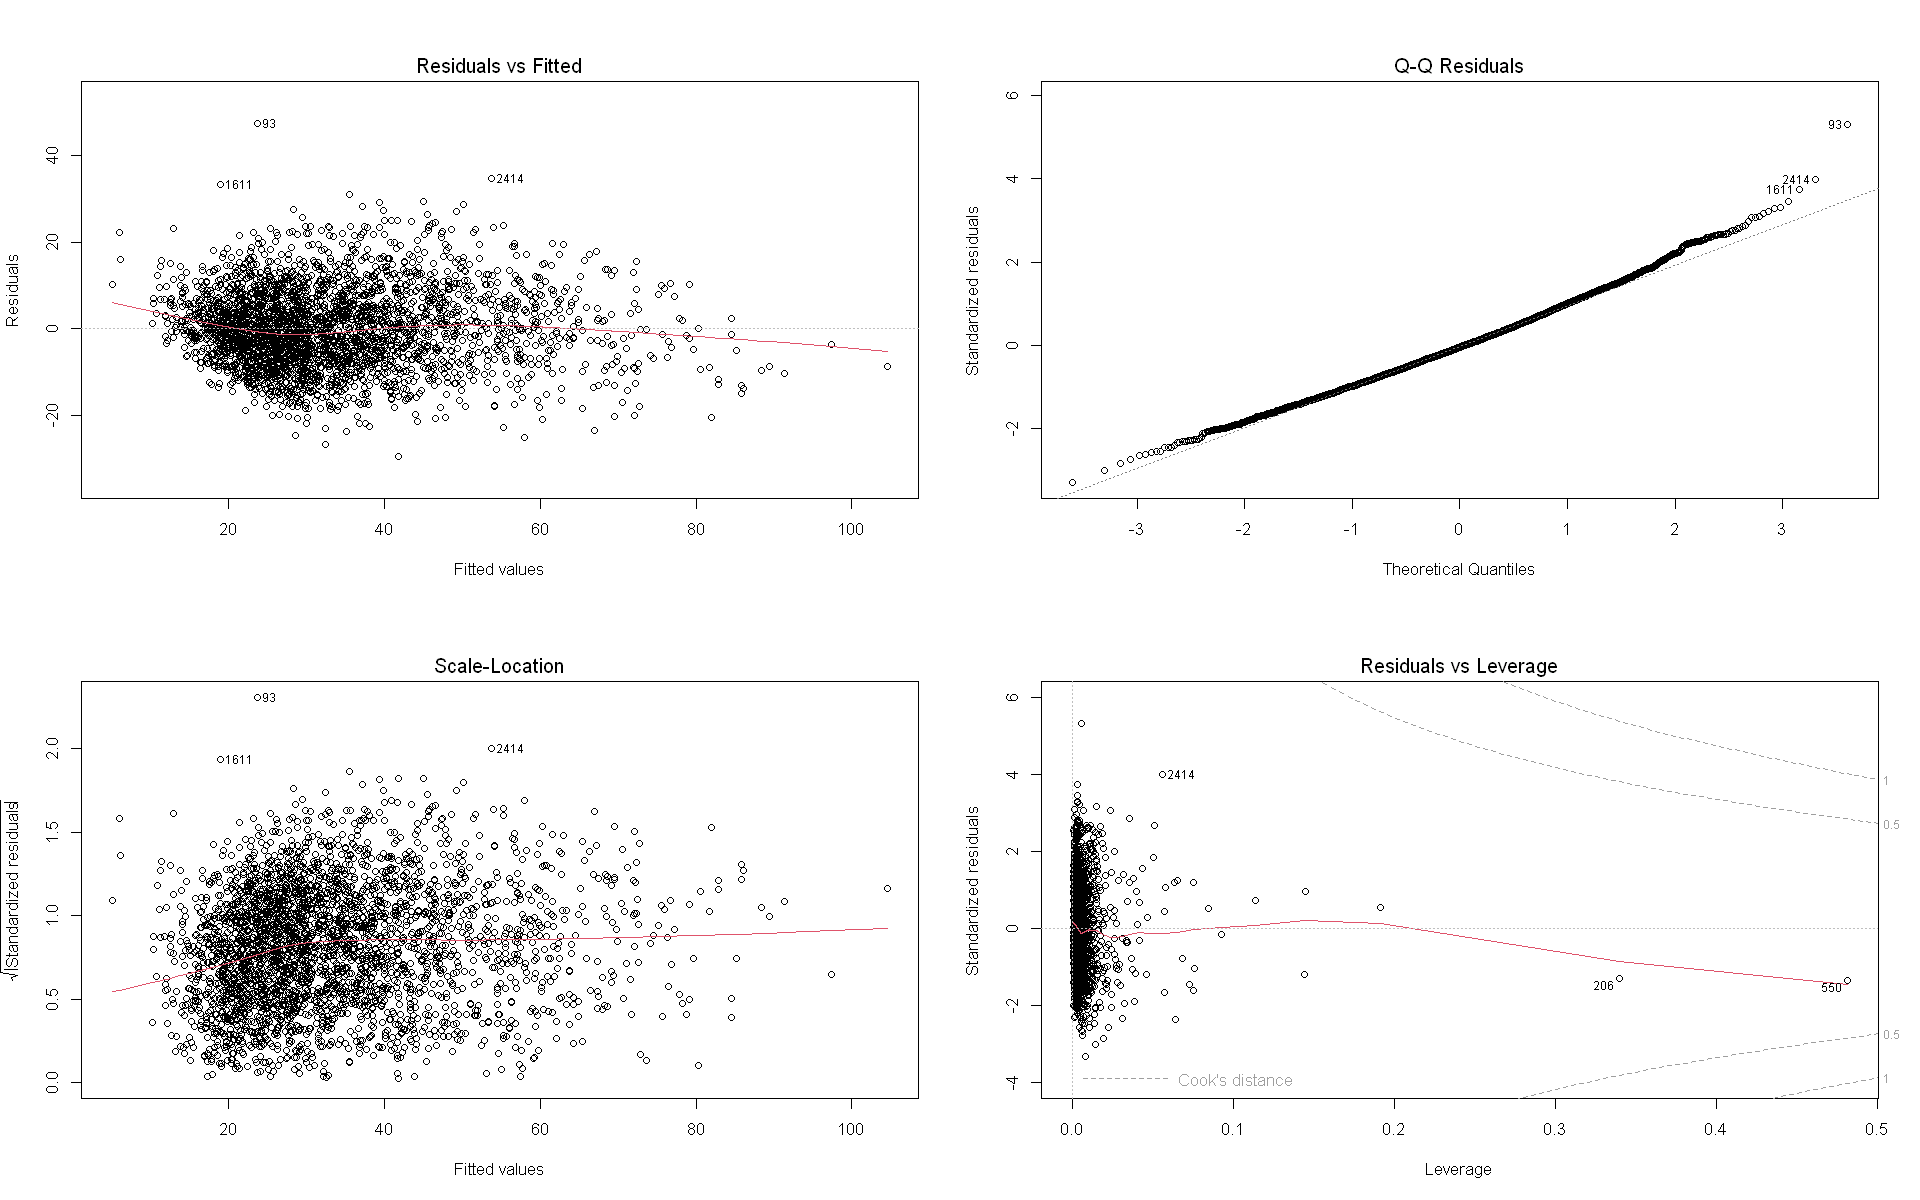

In [32]:
par(mfrow = c(2, 2))
plot(lm_model)

В Residuals vs Fitted графиката виждаме, че нямаме права линия, което показва хетероскедастичност (стандартното отклонение на грешките не е еднакво навсякъде). В Q-Q residuals графиката се проверява дали остатъците са нормално разпределени. Както се вижда, не са, защото има outlier-и. </br>
Имайки предвид това, че работим с изборни и демографски данни, е ясно, че няма как да се направи перфектен модел, който да предсказва изборни резултати, понеже винаги има outlier-и в поведението на избирателите.

#### Регресионни уравнения
Представяме регресионното уравнение на линейния модел така:

In [33]:
coefs <- coef(lm_model)
equation <- paste0("Democrat_vote_pct = ", round(coefs[1], 4), " + ",
                   paste(paste0(round(coefs[-1], 4), " * ", names(coefs)[-1]), collapse = " + "))
cat(equation)

Democrat_vote_pct = 845.9509 + 0.1767 * Population.with.less.than.9th.grade.education + 0.5879 * High.School.graduate.and.equivalent + 1.1412 * Associates.Degree + 0.6969 * Bachelors.Degree + 0 * Total.Population + 1.8902 * Graduate.or.professional.degree + -8.785 * NH.White.percentage + -1e-04 * Median.income..dollars. + -8.1724 * NH.Black.percentage + -8.2735 * NH.Asian.percentage + -8.4679 * Hispanic.or.Latino.percentage + -8.2395 * NH.American.Indian.and.Alaska.Native.percentage + -7.5097 * NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage + -8.7773 * NH.Two.or.More.Races.percentage

А на логистичния модел така:

In [34]:
coefs <- coef(log_model)
equation <- paste0("Democrat_vote_pct = ", round(coefs[1], 4), " + ",
                   paste(paste0(round(coefs[-1], 4), " * ", names(coefs)[-1]), collapse = " + "))
cat(equation)

Democrat_vote_pct = 114.5663 + 0.1088 * High.School.graduate.and.equivalent + 0.1488 * Associates.Degree + 0.1942 * Bachelors.Degree + 0 * Total.Population + 0.3529 * Graduate.or.professional.degree + 0 * Median.income..dollars. + -1.2992 * NH.White.percentage + -1.1753 * NH.Black.percentage + -1.2059 * NH.Asian.percentage + -1.208 * Hispanic.or.Latino.percentage + -1.194 * NH.American.Indian.and.Alaska.Native.percentage + -0.9229 * NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage + -1.1815 * NH.Two.or.More.Races.percentage

### Сравнение на моделите
Използваме AIC (Akaike Information Criterion) за сравнение на двата модела.

In [35]:
AIC(lm_model, log_model)

,df,AIC
,<dbl>,<dbl>
lm_model,16,22701.24
log_model,14,1317.08


Забелязваме по-малка стойност на AIC за логистичния модел - затова избираме него. </br>

Нека симулираме резултат, като въведем окръг, за който бихме били сигурни, че ще бъде спечелен от Демократите:

In [36]:
new_county <- data.frame(
    Population.with.less.than.9th.grade.education = 2,
    High.School.graduate.and.equivalent = 4.617,
    Associates.Degree = 12,
    Bachelors.Degree = 20,
    Graduate.or.professional.degree = 25,
    Median.income..dollars.  = 80000,
    NH.White.percentage = 35,
    NH.Black.percentage = 40,
    NH.Asian.percentage = 5,
    Total.Population = 300000,
    Hispanic.or.Latino.percentage = 15,
    NH.American.Indian.and.Alaska.Native.percentage = 1,
    NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage = 2,
    NH.Two.or.More.Races.percentage = 2
)

Този хипотетичен окръг наподобява окръг, в който има голям град. Това е така, поради голямото население (300000 души), хетерогенното население, сравнително високият процент хора с висше образование и медианата на доходи, която е над средната за страната. Нека видим предсказанията:

In [37]:
print_outcomes_log <- function(model, county) {
    res <- predict(model, newdata = county, type = "response")
    cat("Probability of Democrats winning is:", res, "\n")
    cat("Probability of Republicans winning is approximately:", 1 - res, "\n")
    cat("Projected winner is:", ifelse(res > 0.5, "Democrats", "Republicans"))
}
print_outcomes_lm <- function(model, county) {
    res <- predict(model, newdata = county, type = "response")
    cat("Democrats result is:", res, "\n")
    cat("Republicans result is approximately:", 100 - res, "\n")
    cat("Projected winner is:", ifelse(res > 50, "Democrats", "Republicans"))
}

print_outcomes_log(log_model, new_county)
cat("\n\n")
print_outcomes_lm(lm_model, new_county)

Probability of Democrats winning is: 0.9956324 
Probability of Republicans winning is approximately: 0.004367646 
Projected winner is: Democrats

Democrats result is: 74.42809 
Republicans result is approximately: 25.57191 
Projected winner is: Democrats

## Заключение
В този проект са анализирани данни за всеки окръг за изборите през 2020 година в САЩ и на тяхна база се постига сравнително добро прогнозиране на резултати. Разработените модели – макар и не безупречни – предлагат ценна информация за вероятното поведение на избирателите и потенциалните резултати от изборите.

Бъдещи подобрения биха могли да включват анализиране на данни от и други години (тъй като 2020 година промени доста поведението на гласоподавателите, поради Ковид пандемията), както и внедряване на още демографски показатели.